##Ferdinand Beaman        Capstone Project     April 2024

My students often ask what I'm doing "in school", and more than once I've gotten this response when I tell them:

"That sounds *boooring*"

But when I say "That's because you didn't try to predict stock prices yet",that always raises the eyebrows.

"Day trader" is a surprisingly common self-identifier, despite the fact that most people who try their hand at is are overwhelmingly bad at it. The stock market, on the whole, climbs up in value year after year. But, depending on the source, it's assumed that anywhere between 90 and 99% of people who take part in day trading lose money. My personal hypothesis? Human beings are overconfident pattern seekers and would benefit greatly from some scientific rigor.

> There stands my business problem: Can I use new stock price information (up to an hour old) to predict those in the near future?



The data I'm using comes from https://firstratedata.com/, but in the interest of reprodicibility I should mention that their free samples seem to be tied to the day you request for them. My sample covered an 11 day span of minute-to-minute data beginning near the end of February 2024. (Due to this small sample, I didn't feel the need to account for any cyclical trends).

The seven stocks I chose were based on two criteria: 1) there needed to be enough volume to give the models the best chance and 2) they were in largely different fields.

I chose to use GRU as my NN based on this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9141105/#:~:text=2.4.-,Recurrent%20Neural%20Networks%20(RNNs),time%20intervals%20or%20time%20steps. This ended up paying off quite a bit since some of my cells took over an hour to run. I would not want to rerun them with something more computationally demanding, like an LTSM.

I used a "walk forward" strategy to train my models, and used 5 different step-sizes: 25, 34, 45, 60, and 80 minutes (each step down is a 25% reduction). It quickly became apparent that the 80 minute models didn't have enough room to make enough steps for training and were scrapped midway through.

Remember: Convert change in price to percentage

# 1.0 Data Exploration and Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# !pip install numpy==1.23.0
# One of the later cells refused to function with the newest numpy
import numpy as np

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

from datetime import datetime as dt

from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import keras

In [3]:
print(np.__version__) # I found that it works up to ver 1.25.2

1.25.2


In [4]:
#American Airlines
df_aal = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/AAL_1min_sample.csv")
#Fed Ex
df_fdx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FDX_1min_sample.csv")
#Fidelity National
df_fis = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FIS_1min_sample.csv")
#Macy's
df_mcy = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/M_1min_sample.csv")
#Sprint
df_spr = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/S_1min_sample.csv")
#Starbucks
df_sbx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/SBUX_1min_sample.csv")
#Tesla
df_tsl = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/TSLA_1min_sample.csv")

all_dfs = [df_aal, df_fdx, df_fis, df_mcy, df_sbx, df_spr, df_tsl]

In [72]:
# Example data
all_dfs[0].head()

open   volume
timestamp                            
2024-02-26 08:00:00  15.1396  12650.0
2024-02-26 08:01:00  15.1396  12650.0
2024-02-26 08:02:00  15.1396  12650.0
2024-02-26 08:03:00  15.1396  12650.0
2024-02-26 08:04:00  15.1100   1391.0

How many data points do I have?

In [78]:
for df in all_dfs:
    print(len(df))

20641
20641
20641
20641
20641
20641
20641


Tesla is a fairly popular name in the Zeitgeist here in 2024, so it's no surprise that it shows more movement than anyone else.

In [6]:
# Converting the dfs into datetime data
for df in all_dfs:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
#Checking for null entries
for df in all_dfs:
  print(df.isnull().sum())
  print("\n")

Instead of having null entries, the less popular stocks just don't have rows where nothing happened. Later on, this is addressed by forward-filling.

Ahead, I found the most exclusive boundaries (the latest starting time and the earliest ending time) so I could make all of my data uniform in length.

In [8]:
for df in all_dfs:
    print(df["timestamp"][0])

2024-02-26 04:03:00
2024-02-26 06:09:00
2024-02-26 06:06:00
2024-02-26 04:41:00
2024-02-26 08:00:00
2024-02-26 04:00:00
2024-02-26 04:00:00


In [9]:
for df in all_dfs:
    print(df["timestamp"].iloc[-1])

2024-03-11 19:44:00
2024-03-11 18:11:00
2024-03-11 16:00:00
2024-03-11 19:39:00
2024-03-11 19:04:00
2024-03-11 19:38:00
2024-03-11 19:54:00


8am on the 26th and 4pm on the 11th.

In [10]:
for df in all_dfs:
    df.set_index('timestamp', inplace=True)

In [11]:
#Finally ffilling the dfs, the last serious precursor to concatenation
for i, df in enumerate(all_dfs):
    all_dfs[i] = df.resample("1min").asfreq().ffill()

In [12]:
for i, df in enumerate(all_dfs):
    all_dfs[i] = df['2024-02-26 08:00' : "2024-03-11 16:00" ]

In [13]:
# Just removing superfluous columns
for i, df in enumerate(all_dfs):
    all_dfs[i].drop(["high", "low", "close"], axis = 1, inplace = True)

<ipython-input-13-06eb2f43abe5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dfs[i].drop(["high", "low", "close"], axis = 1, inplace = True)


In [14]:
seven_dfs = pd.concat(all_dfs, axis=1)

Woops, didn't realize that the columns would all now have the same names.

In [15]:
cols = ["open_1", "volume_1", "open_2", "volume_2", "open_3",
                   "volume_3", "open_4", "volume_4", "open_5", "volume_5",
                   "open_6", "volume_6", "open_7", "volume_7"]

seven_dfs.set_axis(cols, axis = 1, inplace = True)

<ipython-input-15-af5447aa6638>:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  seven_dfs.set_axis(cols, axis = 1, inplace = True)


To prevent long stretches of time where the price doesn't change by much from ruining my experiment, I removed all of the after-hours data.

In [17]:
seven_dfs["hour"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["hour"][i] = seven_dfs.index[i].hour

seven_dfs["day"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["day"][i] = seven_dfs.index[i].dayofweek


seven_dfs.drop(seven_dfs[(seven_dfs["hour"] < 8) |
                        (seven_dfs["hour"] > 15)].index, inplace = True)
seven_dfs.drop(seven_dfs[seven_dfs["day"] > 4].index, inplace = True)

I only used the first day and a half's worth of data to scale everything else.

In [16]:
# Getting the first one and a half days of data for the initial training set,
# Then using that to scale all of my data.


train_36_hrs = seven_dfs['2024-02-26 08:00' : "2024-02-28 12:00" ]

scaler = StandardScaler()

train_36_hrs[cols] = scaler.fit(train_36_hrs[cols])
seven_dfs[cols] = scaler.transform(seven_dfs[cols])

<ipython-input-16-5950431c8b46>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_36_hrs[cols] = scaler.fit(train_36_hrs[cols])


So what does this all look like now? Here's a sample:

<Axes: xlabel='timestamp'>

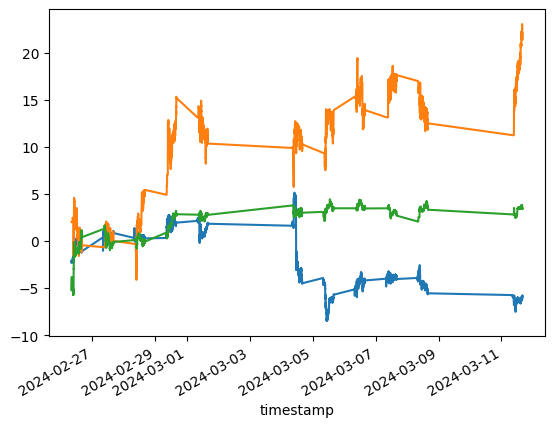

In [20]:
seven_dfs.open_1.plot()
seven_dfs.open_2.plot()
seven_dfs.open_3.plot()

Those long horizontal lines frightened me half to death when I first saw them, but it turns out to not be bad at all (except visually). The graph still includes those after-hours times in the x-axis, so in reality that long bar is just illustrating the difference between two adjacent data points which happen to be far apart in real time.

This was good to see, as there's no obvious pattern to what happens to prices during those times.

There is a question worth asking about this problem on the whole: I'm attempting to train a model to predict stock price movement in small windows of time. How much do they tend to move in a typical hour?

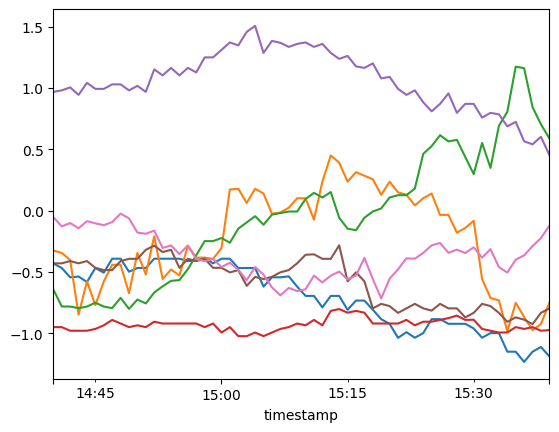

In [21]:
prices = ["open_1", "open_2", "open_3", "open_4", "open_5", "open_6", "open_7"]
for price in prices:
  seven_dfs[price][400:460].plot()

Sometimes, quite a bit! The green line changed an entire standard deviation in about 50 minutes.

What about in an arbitrary half-hour?

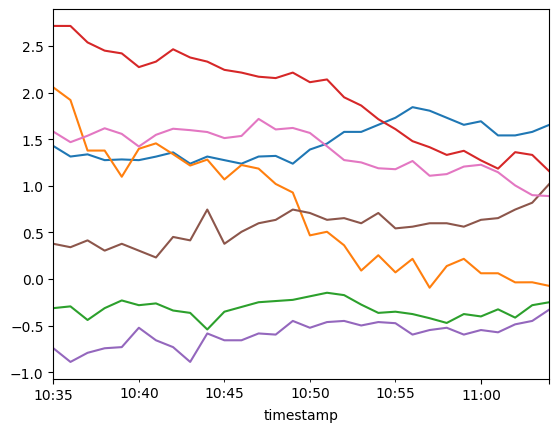

In [79]:
for price in prices:
  seven_dfs[price][515:545].plot()

This time, it's the red and orange lines that are strongly on the move.

Finally, how does this compare to a whole day?

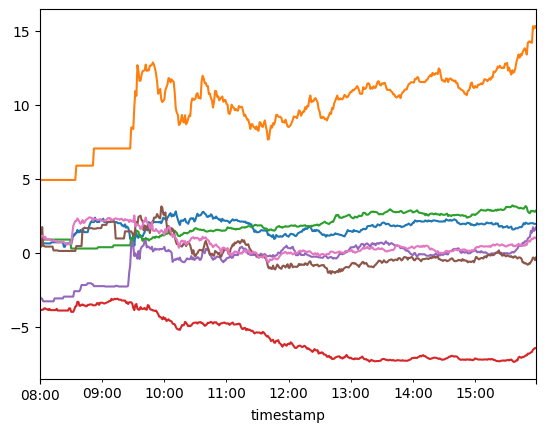

In [22]:
for price in prices:
  seven_dfs[price][1440:1920].plot()

It's a good thing I looked at this, because a lot of the real trading doesn't really start until closer to 9.

In [24]:
#So let's cut that first hour out.
seven_dfs.drop(seven_dfs[seven_dfs["hour"] < 9].index, inplace = True)

In [25]:
len(seven_dfs)

4620

In [26]:
seven_dfs.head()

open_1  volume_1    open_2  volume_2    open_3  \
timestamp                                                               
2024-02-26 09:00:00 -1.718825 -0.227184  2.481364 -0.532078 -4.453081   
2024-02-26 09:01:00 -1.718825 -0.227184  2.481364 -0.532078 -4.453081   
2024-02-26 09:02:00 -1.718825 -0.227184  2.481364 -0.532078 -4.453081   
2024-02-26 09:03:00 -1.718825 -0.227184  2.481364 -0.532078 -4.453081   
2024-02-26 09:04:00 -2.022018 -0.228474  2.481364 -0.532078 -4.453081   

                     volume_3    open_4  volume_4    open_5  volume_5  \
timestamp                                                               
2024-02-26 09:00:00 -0.248041 -0.552663 -0.246766  3.020294 -0.089569   
2024-02-26 09:01:00 -0.169387 -0.552663 -0.246766  3.020294 -0.089569   
2024-02-26 09:02:00 -0.169387 -0.552663 -0.246766  3.020294 -0.089569   
2024-02-26 09:03:00 -0.169387 -0.523226 -0.225539  3.020294 -0.089569   
2024-02-26 09:04:00 -0.169387 -0.523226 -0.225539  3.020294 -0.089569   

                       open_6  volume_6    open_7  volume_7  hour  day  
timestamp                                                               
2024-02-26 09:00:00 -3.440951 -0.079279 -3.676290 -0.515833   9.0  0.0  
2024-02-26 09:01:00 -3.440951 -0.079279 -3.676290 -0.509867   9.0  0.0  
2024-02-26 09:02:00 -3.440951 -0.079279 -3.691343 -0.499595   9.0  0.0  
2024-02-26 09:03:00 -3.440951 -0.079279 -3.671273 -0.508306   9.0  0.0  
2024-02-26 09:04:00 -3.440951 -0.079279 -3.696360 -0.457163   9.0  0.0

In [27]:
# Code repurposed from Greg Hogg: https://www.youtube.com/watch?v=c0k-YLQGKjY
def df_to_Xy(df, window):
  df_np = df.to_numpy()
  X = []
  y = []
  for i in range(0, len(df)-window, window):
    row = [a for a in df_np[i:i+window]]
    X.append(row)
    y.append(df_np[i+window][[0,2,4,6,8,10,12]]) # y is just the 7 price cols
  return np.array(X), np.array(y,dtype=np.float32)

In [28]:
X25, y25 = df_to_Xy(seven_dfs, 25)
X34, y34 = df_to_Xy(seven_dfs, 34)
X45, y45 = df_to_Xy(seven_dfs, 45)
X60, y60 = df_to_Xy(seven_dfs, 60)

# 2.0 Building the Model

In [30]:
X_train25, y_train25 = X25[:129], y25[:129] #Just over 70% of the data
X_val25, y_val25 = X25[129:157], y25[129:157]
X_test25, y_test25 = X25[157:], y25[157:]

X_train34, y_train34 = X34[:95], y34[:95]
X_val34, y_val34 = X34[95:115], y34[95:115]
X_test34, y_test34 = X34[115:], y34[115:]

X_train45, y_train45 = X45[:72], y45[:72]
X_val45, y_val45 = X45[72:87], y45[72:87]
X_test45, y_test45 = X45[87:], y45[87:]

X_train60, y_train60 = X60[:55], y60[:55]
X_val60, y_val60 = X60[55:65], y60[55:65]
X_test60, y_test60 = X60[65:], y60[65:]

In [31]:
def pred_plot_col(model, X, y, col):
  y = y[:,col]
  preds = model.predict(X)[:,col].flatten()
  df = pd.DataFrame(data={"Predictions":preds, "Actuals":y})
  plt.plot(df["Predictions"][:], label = "Predictions")
  plt.plot(df["Actuals"][:], label = "Actuals")
  plt.legend()
  return mse(y, preds)

def pred_plot_all(model, X, y):
  fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2)
  fig.set_figheight(22)
  fig.set_figwidth(15)
  axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
  for i, ax in enumerate(axes):
    actual = y[:,i].flatten()
    preds = model.predict(X)[:,i].flatten()
    ax = ax
    ax.plot(preds)
    ax.plot(actual)
    ax.legend(["Prediction", "Actual"])
    plt.legend()
  plt.show()

In [32]:
def plot_error(history):
  hist_dict = history.history
  rmse = hist_dict["root_mean_squared_error"]
  v_rmse = hist_dict["val_root_mean_squared_error"]
  df = pd.DataFrame(data={"Train_error":rmse, "Val_Error":v_rmse})
  plt.plot(df["Train_error"][:], label = "Train error")
  plt.plot(df["Val_Error"][:], label = "Val Error")
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

I chose two variables to adjust, and each one has two states:

Learning rate, which is either
Default (0.0001) or Fast (0.01).
Number of hidden layers: Short (2) vs Long (4)

In [33]:
# All of the training and validation datasets
the_X_trains = [X_train25, X_train34, X_train45, X_train60]
the_y_trains = [y_train25, y_train34, y_train45, y_train60]

the_X_vals = [X_val25, X_val34, X_val45, X_val60]
the_y_vals = [y_val25, y_val34, y_val45, y_val60]


## Instantiating models, checkpoints, and what will be their histories,
## then putting all of them in lists

# Default/Short
mod_25_DeSh = Sequential()
mod_34_DeSh = Sequential()
mod_45_DeSh = Sequential()
mod_60_DeSh = Sequential()

cp_25_DeSh = ModelCheckpoint("model_25_DeSh/", save_best_only=True)
cp_34_DeSh = ModelCheckpoint("model_34_DeSh/", save_best_only=True)
cp_45_DeSh = ModelCheckpoint("model_45_DeSh/", save_best_only=True)
cp_60_DeSh = ModelCheckpoint("model_60_DeSh/", save_best_only=True)

hist_25_DeSh = None
hist_34_DeSh = None
hist_45_DeSh = None
hist_60_DeSh = None

mods_DeSh = [mod_25_DeSh, mod_34_DeSh, mod_45_DeSh, mod_60_DeSh]

cps_DeSh = [cp_25_DeSh, cp_34_DeSh, cp_45_DeSh, cp_60_DeSh]

hists_DeSh = [hist_25_DeSh, hist_34_DeSh, hist_45_DeSh, hist_60_DeSh]

# Fast/Short
mod_25_FaSh = Sequential()
mod_34_FaSh = Sequential()
mod_45_FaSh = Sequential()
mod_60_FaSh = Sequential()

cp_25_FaSh = ModelCheckpoint("model_25_FaSh/", save_best_only=True)
cp_34_FaSh = ModelCheckpoint("model_34_FaSh/", save_best_only=True)
cp_45_FaSh = ModelCheckpoint("model_45_FaSh/", save_best_only=True)
cp_60_FaSh = ModelCheckpoint("model_60_FaSh/", save_best_only=True)

hist_25_FaSh = None
hist_34_FaSh = None
hist_45_FaSh = None
hist_60_FaSh = None

mods_FaSh = [mod_25_FaSh, mod_34_FaSh, mod_45_FaSh, mod_60_FaSh]

cps_FaSh = [cp_25_FaSh, cp_34_FaSh, cp_45_FaSh, cp_60_FaSh]

hists_FaSh = [hist_25_FaSh, hist_34_FaSh, hist_45_FaSh, hist_60_FaSh]

# Default/Long
mod_25_DeLo = Sequential()
mod_34_DeLo = Sequential()
mod_45_DeLo = Sequential()
mod_60_DeLo = Sequential()

cp_25_DeLo = ModelCheckpoint("model_25_DeLo/", save_best_only=True)
cp_34_DeLo = ModelCheckpoint("model_34_DeLo/", save_best_only=True)
cp_45_DeLo = ModelCheckpoint("model_45_DeLo/", save_best_only=True)
cp_60_DeLo = ModelCheckpoint("model_60_DeLo/", save_best_only=True)

hist_25_DeLo = None
hist_34_DeLo = None
hist_45_DeLo = None
hist_60_DeLo = None

mods_DeLo = [mod_25_DeLo, mod_34_DeLo, mod_45_DeLo, mod_60_DeLo]

cps_DeLo = [cp_25_DeLo, cp_34_DeLo, cp_45_DeLo, cp_60_DeLo]

hists_DeLo = [hist_25_DeLo, hist_34_DeLo, hist_45_DeLo, hist_60_DeLo]

# Fast/Long
mod_25_FaLo = Sequential()
mod_34_FaLo = Sequential()
mod_45_FaLo = Sequential()
mod_60_FaLo = Sequential()

cp_25_FaLo = ModelCheckpoint("model_25_FaLo/", save_best_only=True)
cp_34_FaLo = ModelCheckpoint("model_34_FaLo/", save_best_only=True)
cp_45_FaLo = ModelCheckpoint("model_45_FaLo/", save_best_only=True)
cp_60_FaLo = ModelCheckpoint("model_60_FaLo/", save_best_only=True)

hist_25_FaLo = None
hist_34_FaLo = None
hist_45_FaLo = None
hist_60_FaLo = None

mods_FaLo = [mod_25_FaLo, mod_34_FaLo, mod_45_FaLo, mod_60_FaLo]

cps_FaLo = [cp_25_FaLo, cp_34_FaLo, cp_45_FaLo, cp_60_FaLo]

hists_FaLo = [hist_25_FaLo, hist_34_FaLo, hist_45_FaLo, hist_60_FaLo]

For the models with an accelerated learning rate, I gave them a maximum of 25 epochs to train. The default learning rate was given 100 epochs. These slower models were also given a little more leeway with the early stopping parameter (patience = 5 instead of 3, start_from_epoch = 10 instead of 5).

In [34]:
# Default and Short models
for i, n in enumerate([25, 34, 45, 60]):
  mods_DeSh[i].add(InputLayer((n,16)))
  mods_DeSh[i].add(GRU(64))
  mods_DeSh[i].add(Dense(16, "relu"))
  mods_DeSh[i].add(Dense(14, "relu"))
  mods_DeSh[i].add(Dense(7, "linear"))

  mods_DeSh[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.0001),
                        metrics=[RootMeanSquaredError()])

  print("Default and Short, samples = " + str(n))
  hists_DeSh[i] = mods_DeSh[i].fit(the_X_trains[i], the_y_trains[i],
      validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 300,
      callbacks = [cps_DeSh[i], EarlyStopping(patience=5, start_from_epoch=10)])

  print("\n")
  print("\n")

Default and Short, samples = 25
Epoch 1/300
5/5 [==============================] - 7s 1s/step - loss: 25.0848 - root_mean_squared_error: 5.0085 - val_loss: 63.0023 - val_root_mean_squared_error: 7.9374
Epoch 2/300
5/5 [==============================] - 3s 785ms/step - loss: 24.8058 - root_mean_squared_error: 4.9805 - val_loss: 62.3628 - val_root_mean_squared_error: 7.8970
Epoch 3/300
5/5 [==============================] - 3s 774ms/step - loss: 24.5276 - root_mean_squared_error: 4.9525 - val_loss: 61.7420 - val_root_mean_squared_error: 7.8576
Epoch 4/300
5/5 [==============================] - 4s 980ms/step - loss: 24.2476 - root_mean_squared_error: 4.9242 - val_loss: 61.1533 - val_root_mean_squared_error: 7.8201
Epoch 5/300
5/5 [==============================] - 4s 878ms/step - loss: 24.0007 - root_mean_squared_error: 4.8991 - val_loss: 60.5625 - val_root_mean_squared_error: 7.7822
Epoch 6/300
5/5 [==============================] - 3s 760ms/step - loss: 23.7666 - root_mean_squared_error

In [35]:
for i, n in enumerate([25, 34, 45, 60]):
  print(str(min(hists_DeSh[i].history['val_root_mean_squared_error'])
  ) + " = Default/Short best Val RMSE with samples sized " + str(n))
  print("\n")

1.8256580829620361 = Default/Short best Val RMSE with samples sized 25


3.0903689861297607 = Default/Short best Val RMSE with samples sized 34


2.8653337955474854 = Default/Short best Val RMSE with samples sized 45


3.0381486415863037 = Default/Short best Val RMSE with samples sized 60




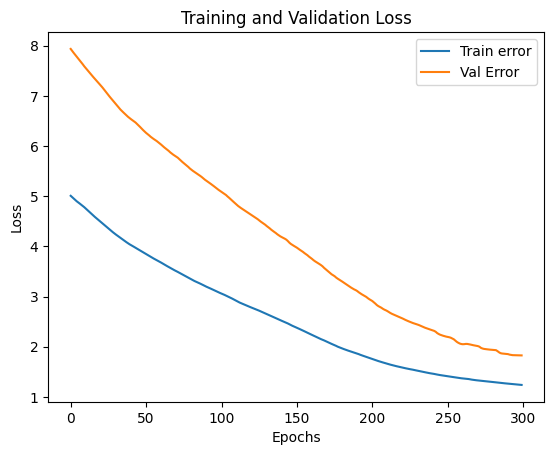

In [36]:
plot_error(hists_DeSh[0])

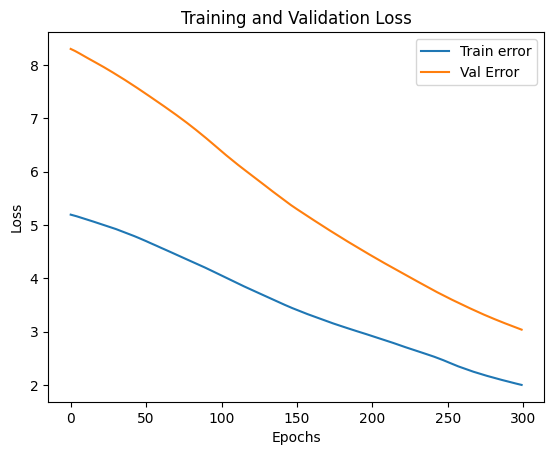

In [37]:
plot_error(hists_DeSh[3])

1/1 [==============================] - 1s 582ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 34ms/step


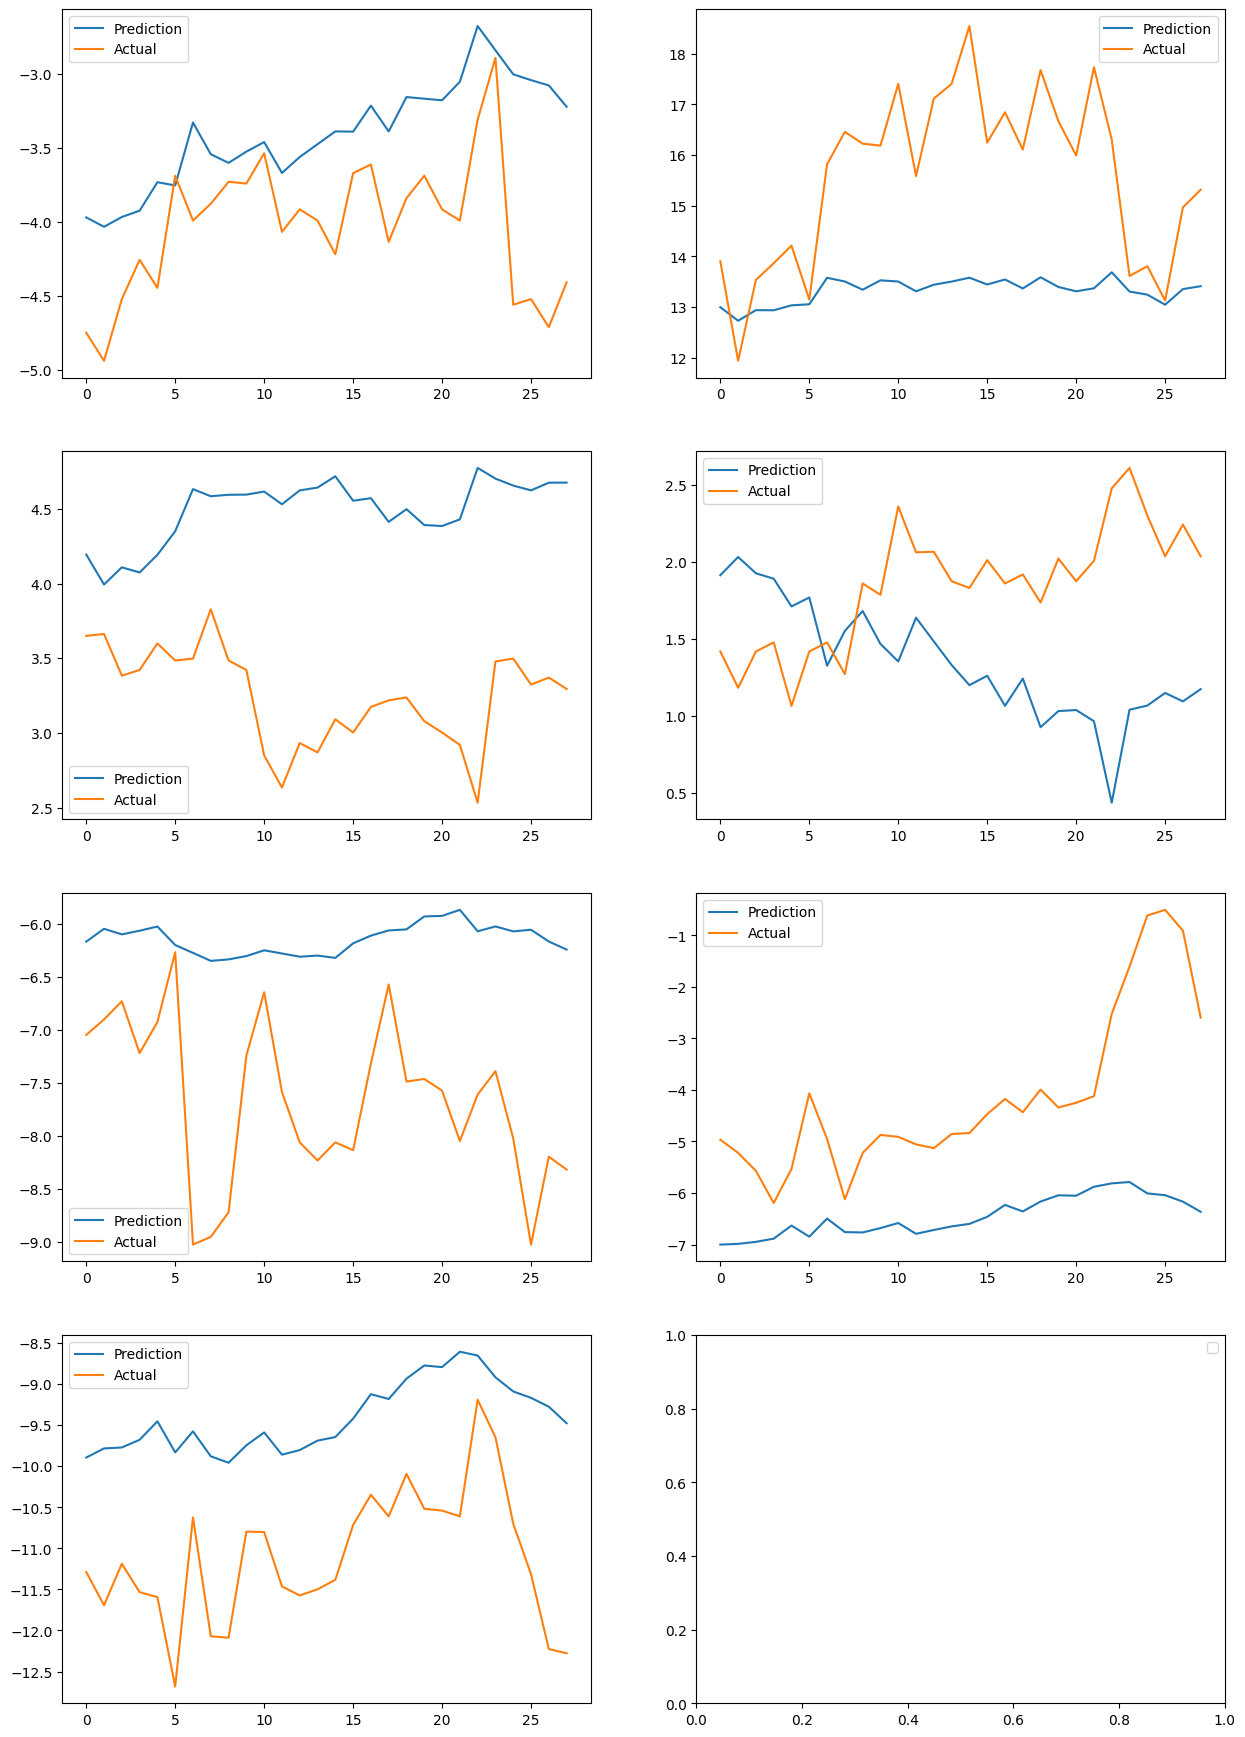

In [38]:
pred_plot_all(mod_25_DeSh, X_val25, y_val25)

1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


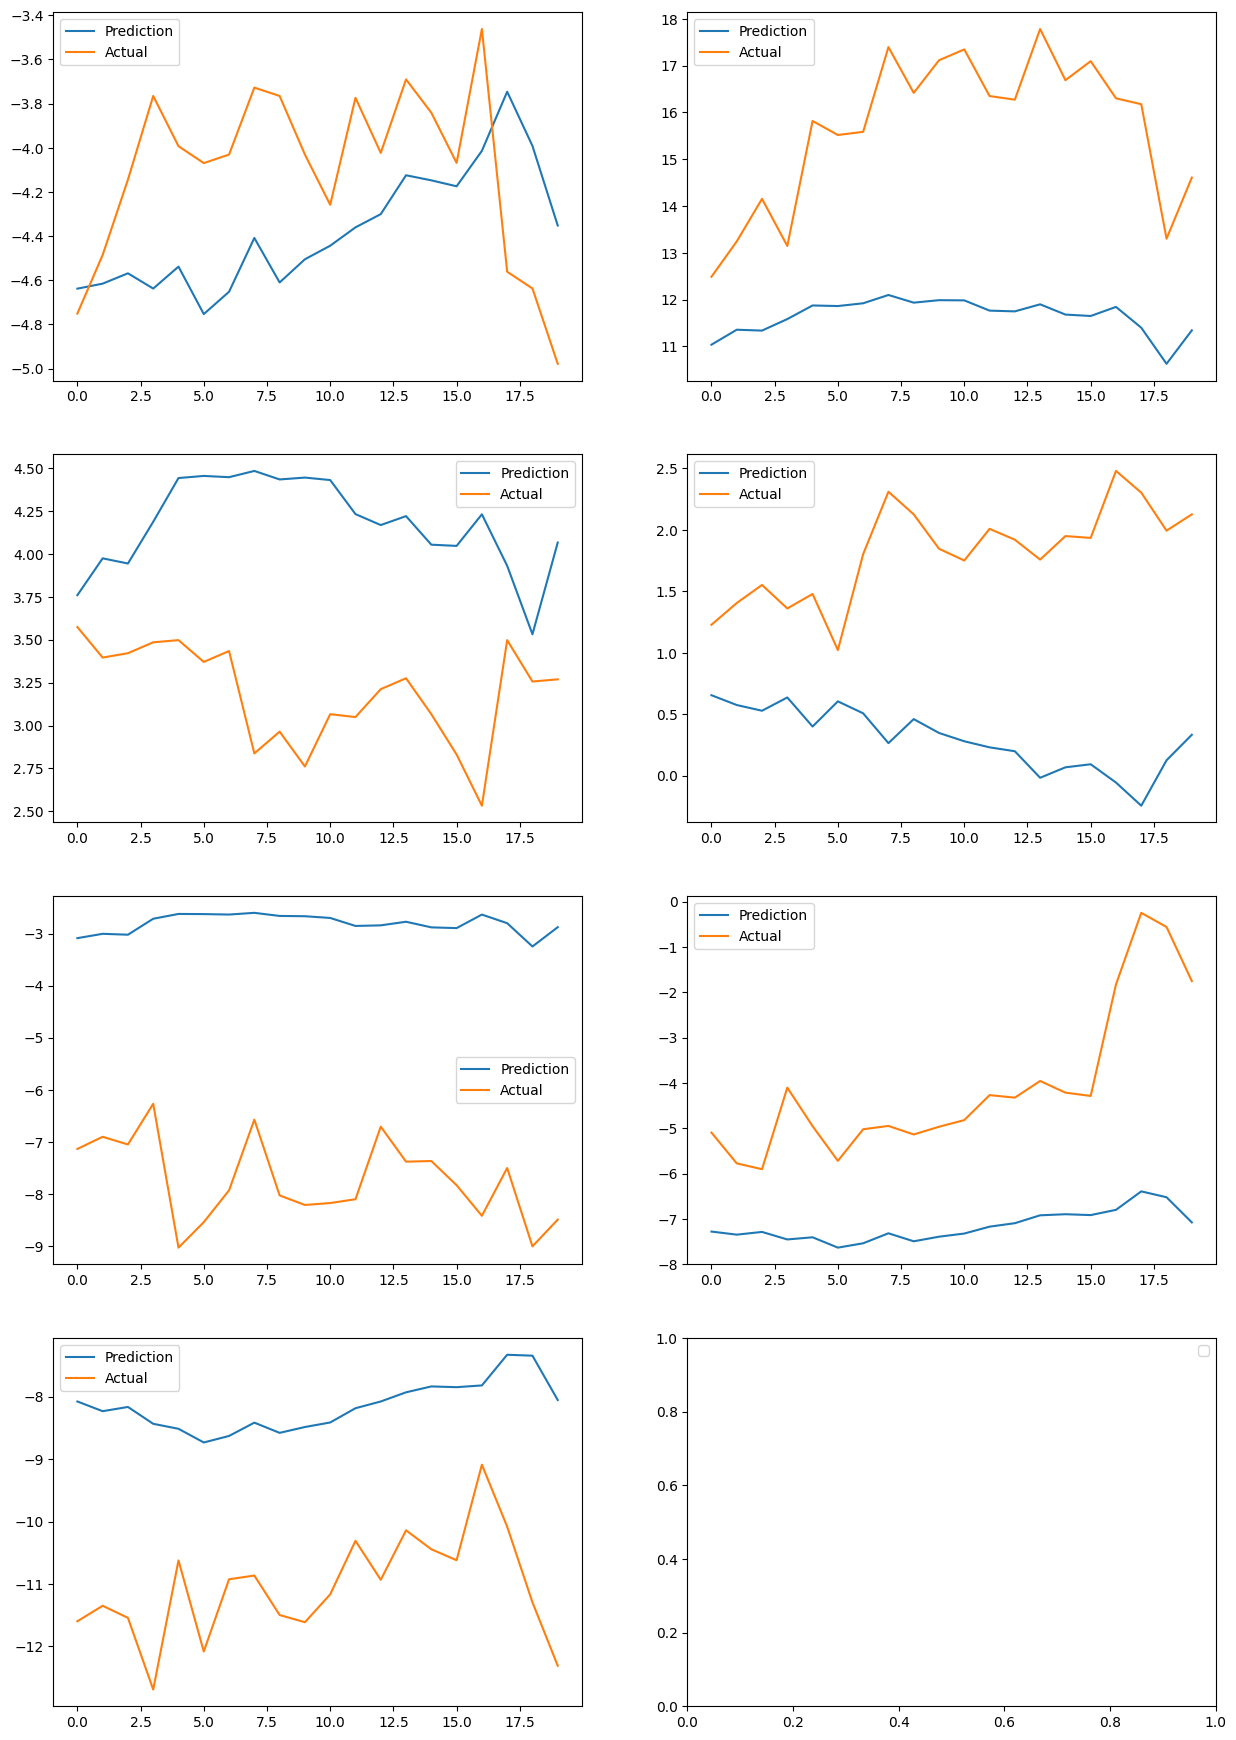

In [39]:
pred_plot_all(mod_34_DeSh, X_val34, y_val34)

1/1 [==============================] - 0s 419ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


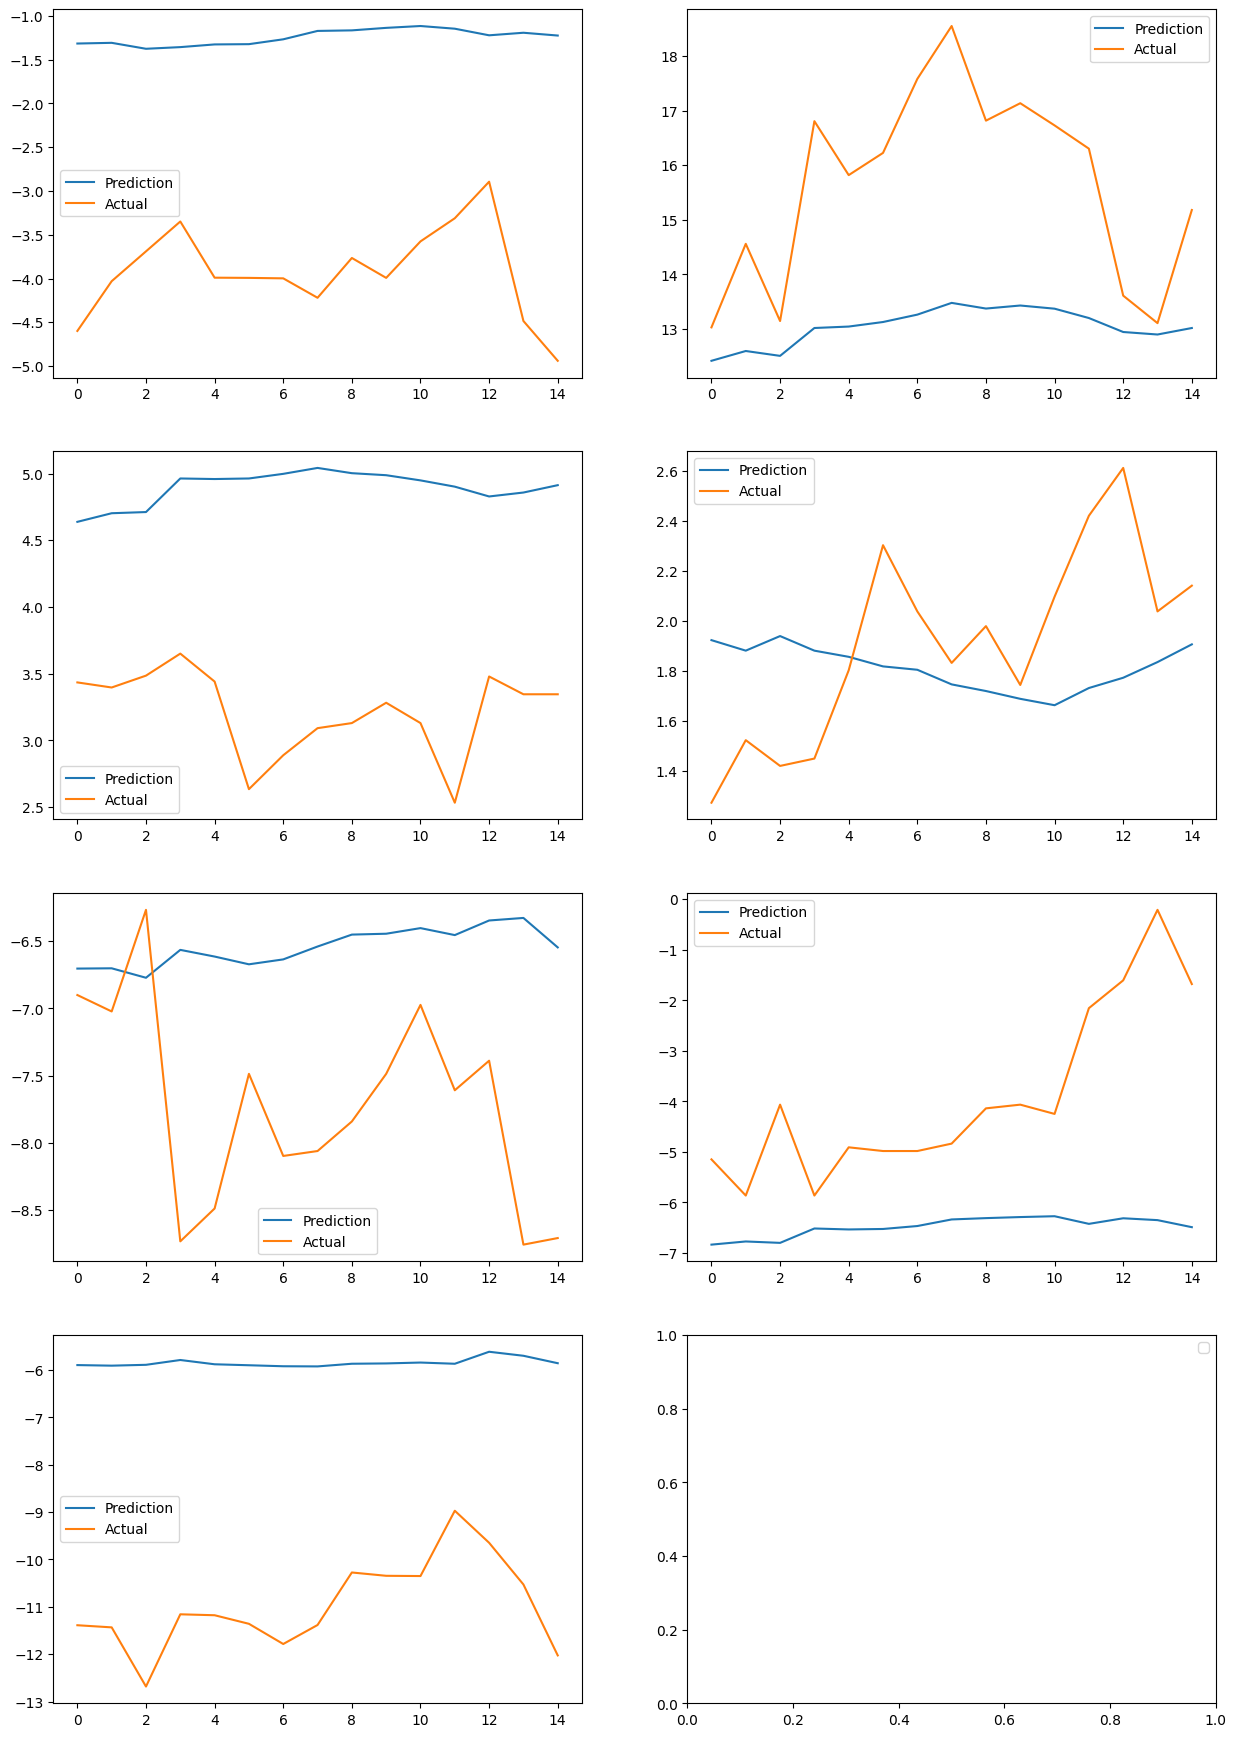

In [40]:
pred_plot_all(mod_45_DeSh, X_val45, y_val45)

1/1 [==============================] - 0s 427ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


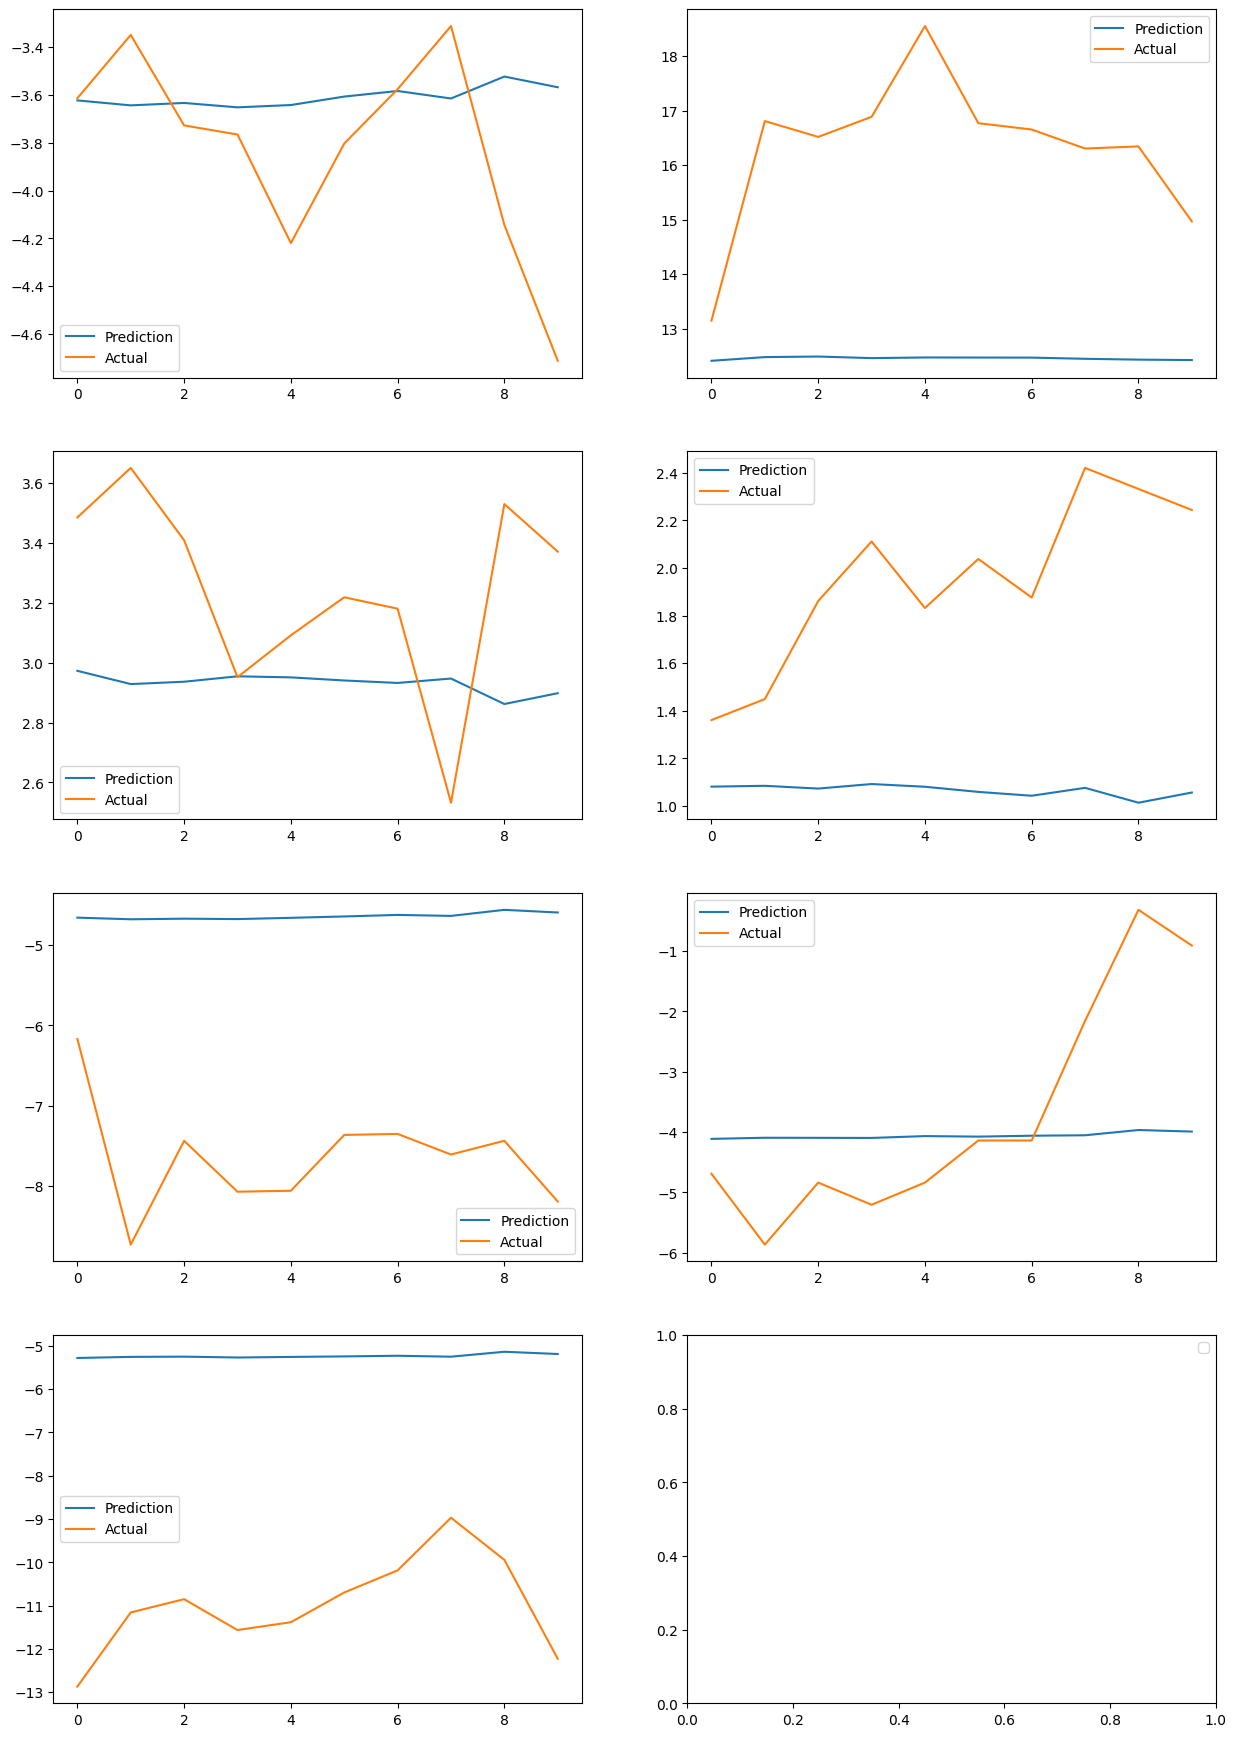

In [41]:
pred_plot_all(mod_60_DeSh, X_val60, y_val60)

In [42]:
# Default and Long models
for i, n in enumerate([25, 34, 45, 60]):
  mods_DeLo[i].add(InputLayer((n,16)))
  mods_DeLo[i].add(GRU(64))
  mods_DeLo[i].add(Dense(16, "relu"))
  mods_DeLo[i].add(Dense(16, "relu"))
  mods_DeLo[i].add(Dense(15, "relu"))
  mods_DeLo[i].add(Dense(14, "relu"))
  mods_DeLo[i].add(Dense(7, "linear"))

  mods_DeLo[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.0001),
                        metrics=[RootMeanSquaredError()])

  print("Default and Long, samples = " + str(n))
  hists_DeLo[i] = mods_DeLo[i].fit(the_X_trains[i], the_y_trains[i],
      validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 300,
      callbacks = [cps_DeLo[i], EarlyStopping(patience=5, start_from_epoch=10)])


  print("\n")
  print("\n")

Default and Long, samples = 25
Epoch 1/300
5/5 [==============================] - 7s 964ms/step - loss: 26.5536 - root_mean_squared_error: 5.1530 - val_loss: 68.1328 - val_root_mean_squared_error: 8.2543
Epoch 2/300
5/5 [==============================] - 4s 1s/step - loss: 26.4815 - root_mean_squared_error: 5.1460 - val_loss: 68.0363 - val_root_mean_squared_error: 8.2484
Epoch 3/300
5/5 [==============================] - 4s 1s/step - loss: 26.4207 - root_mean_squared_error: 5.1401 - val_loss: 67.9806 - val_root_mean_squared_error: 8.2450
Epoch 4/300
5/5 [==============================] - 4s 872ms/step - loss: 26.3675 - root_mean_squared_error: 5.1349 - val_loss: 67.9523 - val_root_mean_squared_error: 8.2433
Epoch 5/300
5/5 [==============================] - 4s 1s/step - loss: 26.3221 - root_mean_squared_error: 5.1305 - val_loss: 67.9240 - val_root_mean_squared_error: 8.2416
Epoch 6/300
5/5 [==============================] - 4s 1s/step - loss: 26.2816 - root_mean_squared_error: 5.1266 -

In [43]:
for i, n in enumerate([25, 34, 45, 60]):
  print(str(min(hists_DeLo[i].history['val_root_mean_squared_error'])
  ) + " = Default/Long best Val RMSE with samples sized " + str(n))
  print("\n")

3.3302271366119385 = Default/Long best Val RMSE with samples sized 25


2.0875723361968994 = Default/Long best Val RMSE with samples sized 34


2.287993907928467 = Default/Long best Val RMSE with samples sized 45


4.6829938888549805 = Default/Long best Val RMSE with samples sized 60




1/1 [==============================] - 1s 613ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


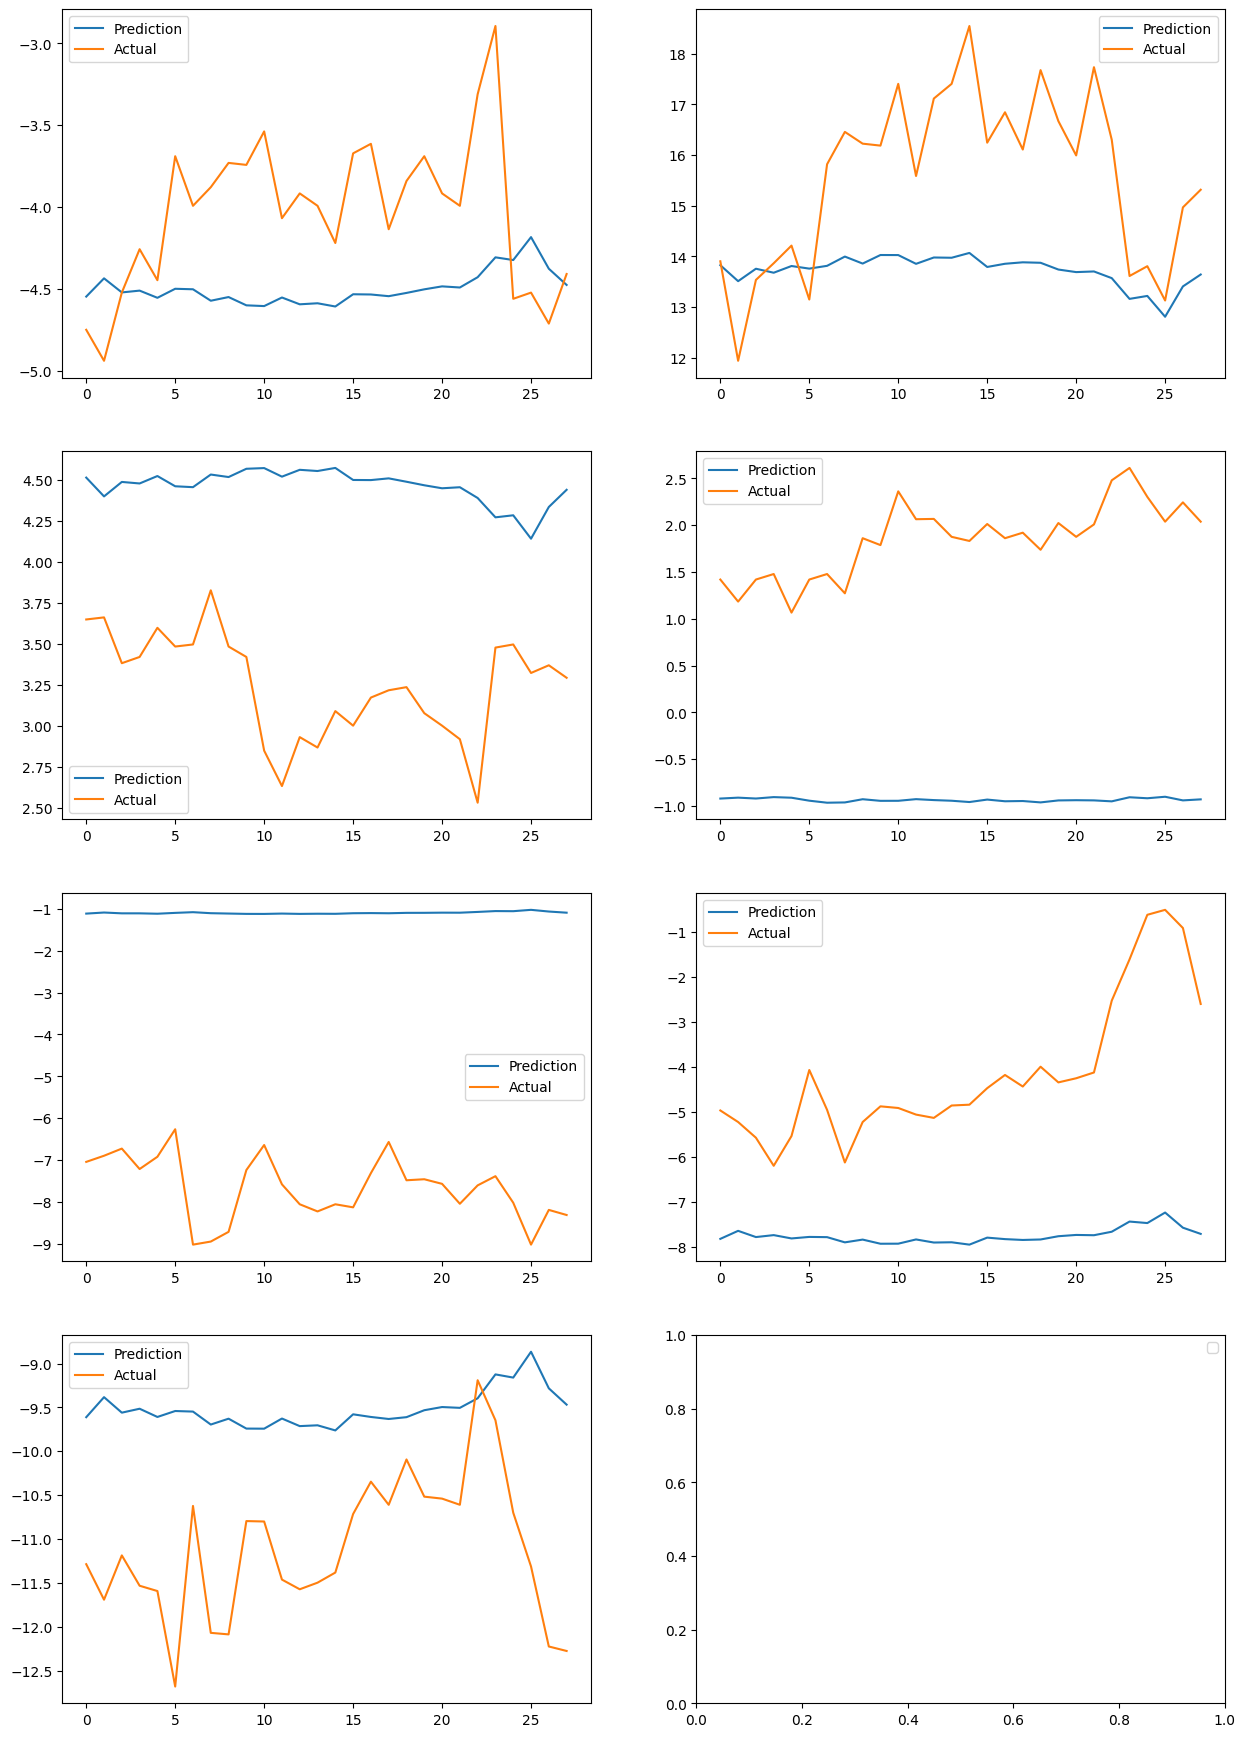

In [44]:
pred_plot_all(mod_25_DeLo, X_val25, y_val25)

In [45]:
# Fast and Short models
for i, n in enumerate([25, 34, 45, 60]):
  mods_FaSh[i].add(InputLayer((n,16)))
  mods_FaSh[i].add(GRU(64))
  mods_FaSh[i].add(Dense(16, "relu"))
  mods_FaSh[i].add(Dense(14, "relu"))
  mods_FaSh[i].add(Dense(7, "linear"))

  mods_FaSh[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.01),
                        metrics=[RootMeanSquaredError()])

  print("Default and Long, samples = " + str(n))
  hists_FaSh[i] = mods_FaSh[i].fit(the_X_trains[i], the_y_trains[i],
  validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 30,
      callbacks = [cps_FaSh[i], EarlyStopping(patience=4, start_from_epoch=6)])



  print("\n")
  print("\n")

Default and Long, samples = 25
Epoch 1/30
5/5 [==============================] - 6s 933ms/step - loss: 20.5201 - root_mean_squared_error: 4.5299 - val_loss: 29.4319 - val_root_mean_squared_error: 5.4251
Epoch 2/30
5/5 [==============================] - 5s 1s/step - loss: 10.4707 - root_mean_squared_error: 3.2358 - val_loss: 11.0985 - val_root_mean_squared_error: 3.3314
Epoch 3/30
5/5 [==============================] - 3s 825ms/step - loss: 4.0346 - root_mean_squared_error: 2.0086 - val_loss: 3.1580 - val_root_mean_squared_error: 1.7771
Epoch 4/30
5/5 [==============================] - 0s 23ms/step - loss: 2.8403 - root_mean_squared_error: 1.6853 - val_loss: 3.5071 - val_root_mean_squared_error: 1.8727
Epoch 5/30
5/5 [==============================] - 0s 25ms/step - loss: 2.5198 - root_mean_squared_error: 1.5874 - val_loss: 4.1119 - val_root_mean_squared_error: 2.0278
Epoch 6/30
5/5 [==============================] - 0s 27ms/step - loss: 1.9386 - root_mean_squared_error: 1.3923 - val_lo

In [46]:
for i, n in enumerate([25, 34, 45, 60]):
  print(str(min(hists_FaSh[i].history['val_root_mean_squared_error'])
  ) + " = Fast/Short best Val RMSE with samples sized " + str(n))
  print("\n")

1.4467101097106934 = Fast/Short best Val RMSE with samples sized 25


1.216903805732727 = Fast/Short best Val RMSE with samples sized 34


1.5041409730911255 = Fast/Short best Val RMSE with samples sized 45


1.701181173324585 = Fast/Short best Val RMSE with samples sized 60




1/1 [==============================] - 0s 410ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


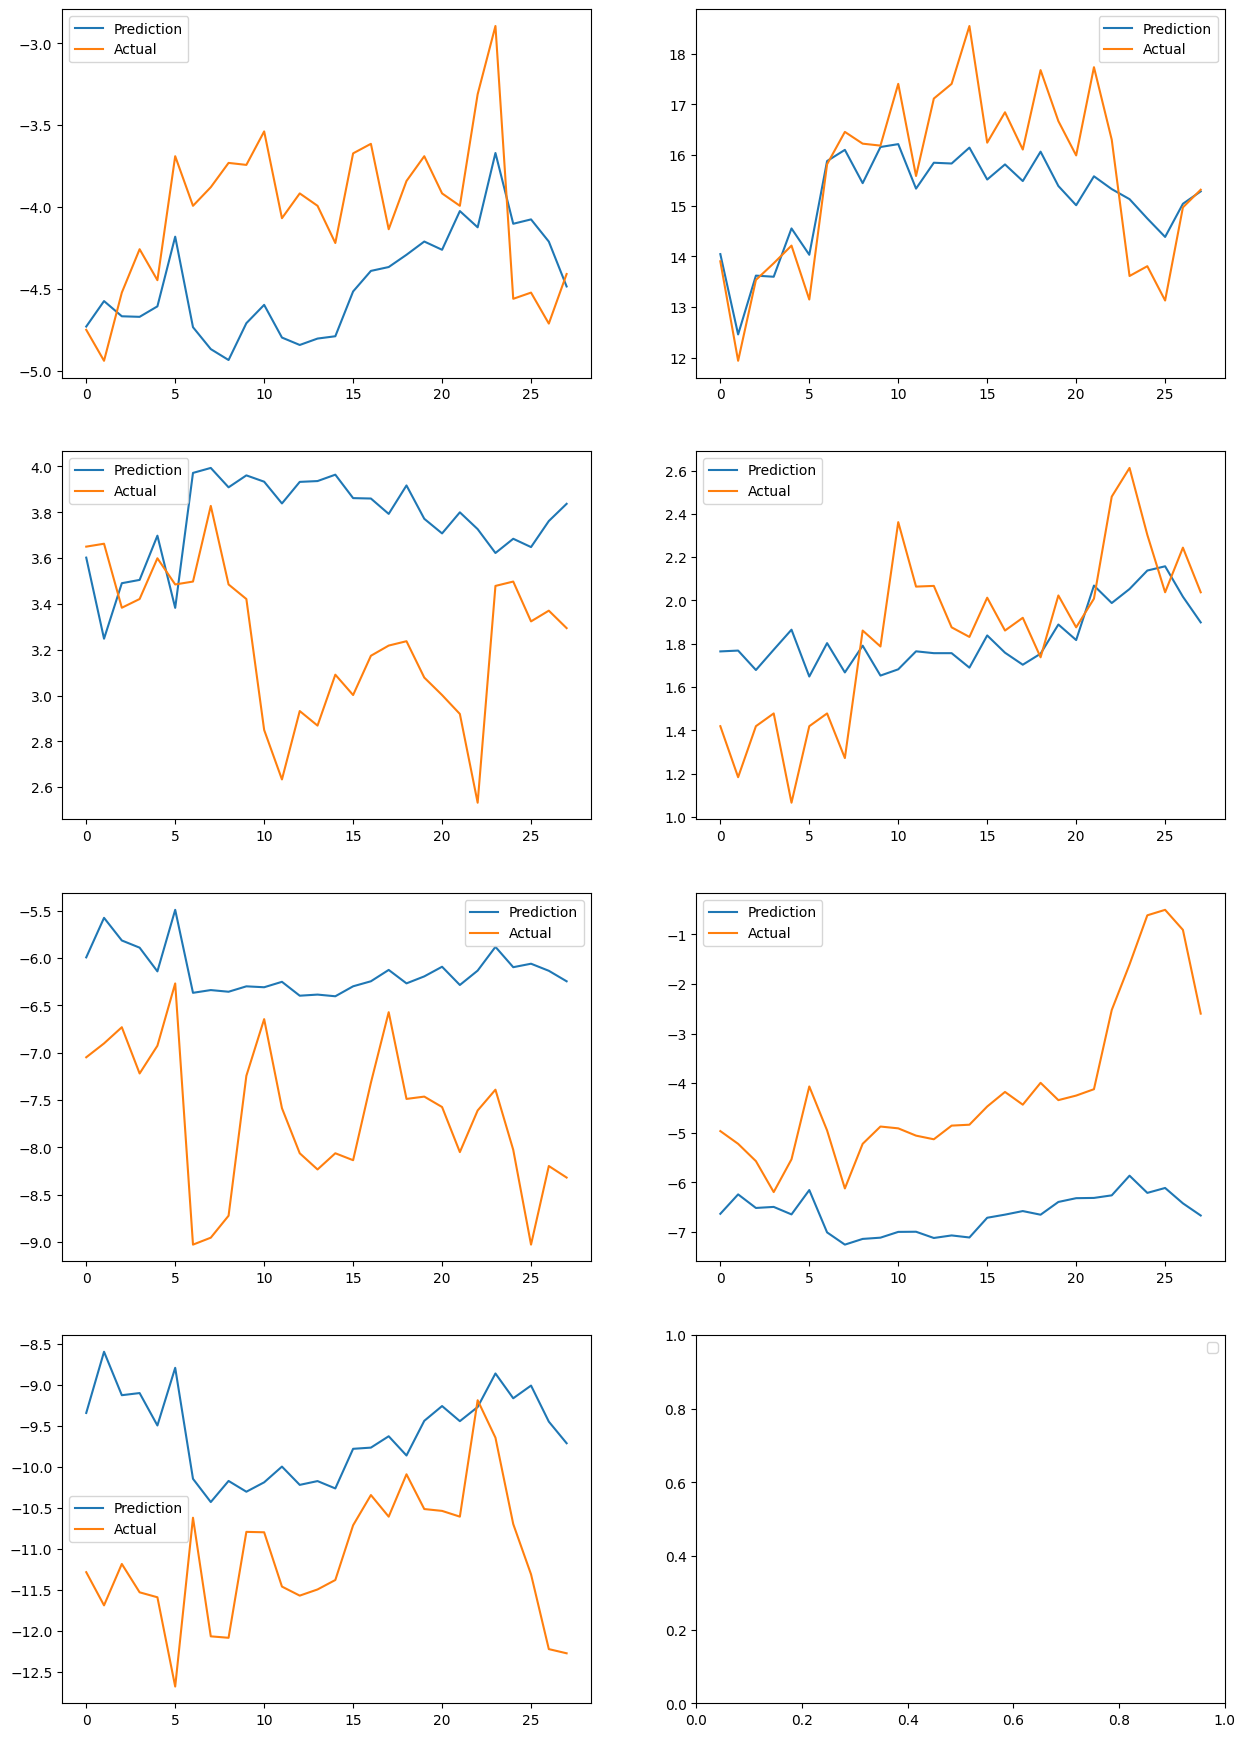

In [47]:
pred_plot_all(mod_25_FaSh, X_val25, y_val25)

1/1 [==============================] - 0s 412ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


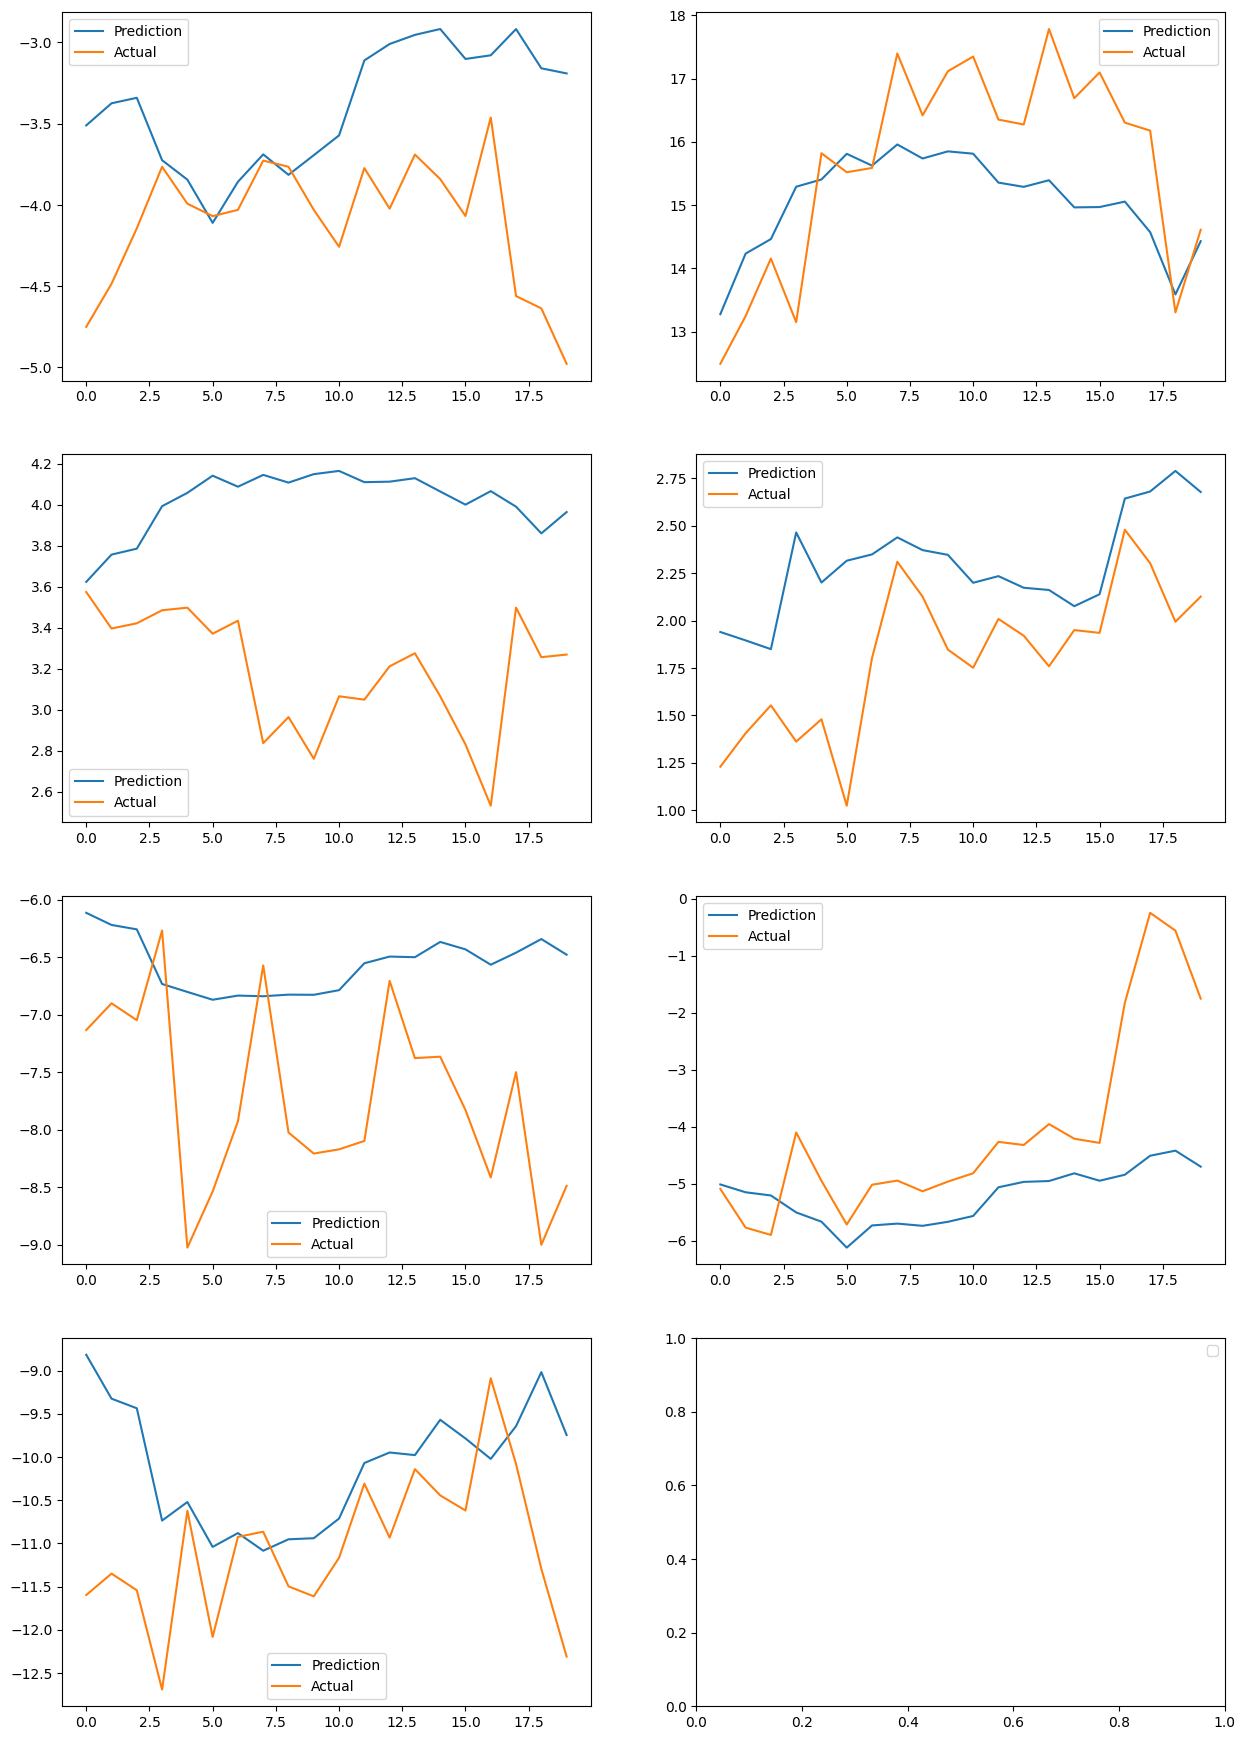

In [48]:
pred_plot_all(mod_34_FaSh, X_val34, y_val34)

1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


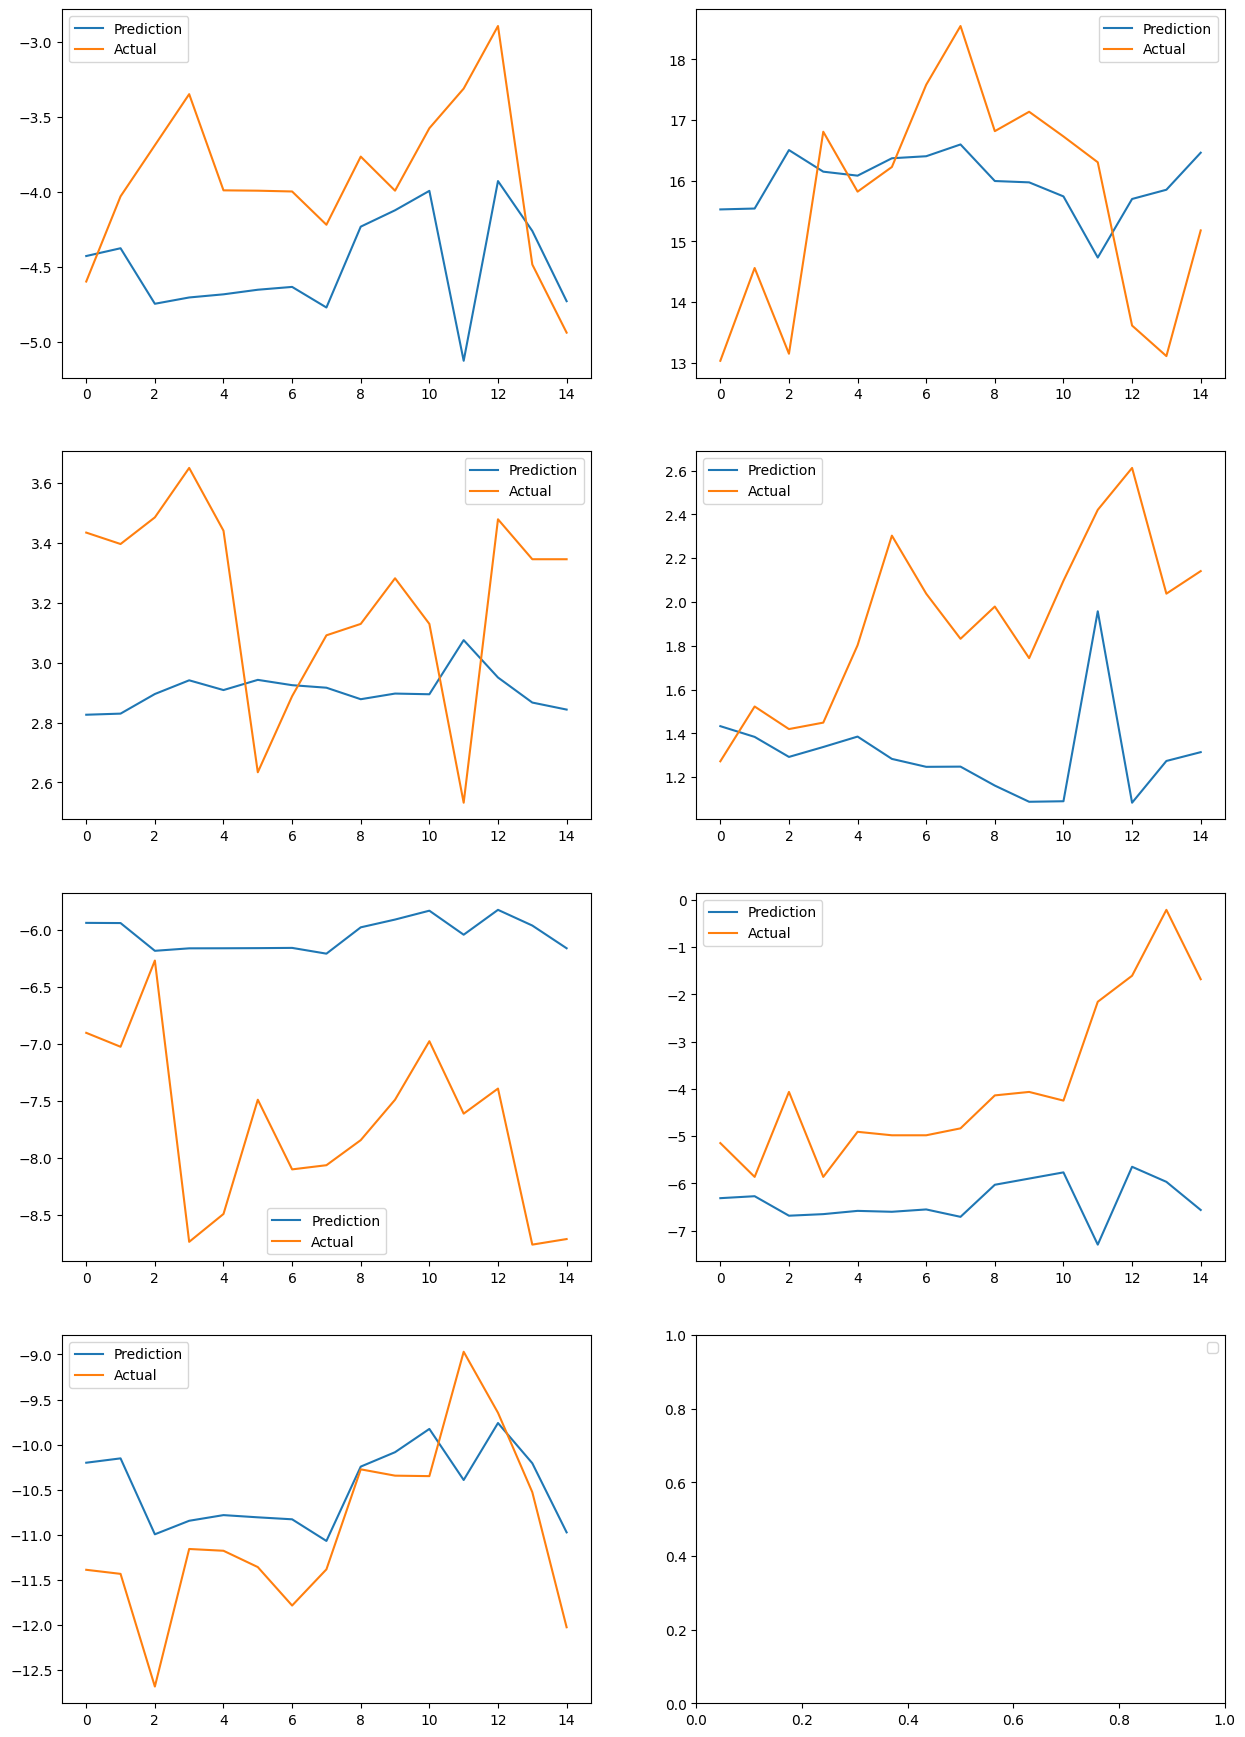

In [49]:
pred_plot_all(mod_45_FaSh, X_val45, y_val45)

1/1 [==============================] - 0s 444ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


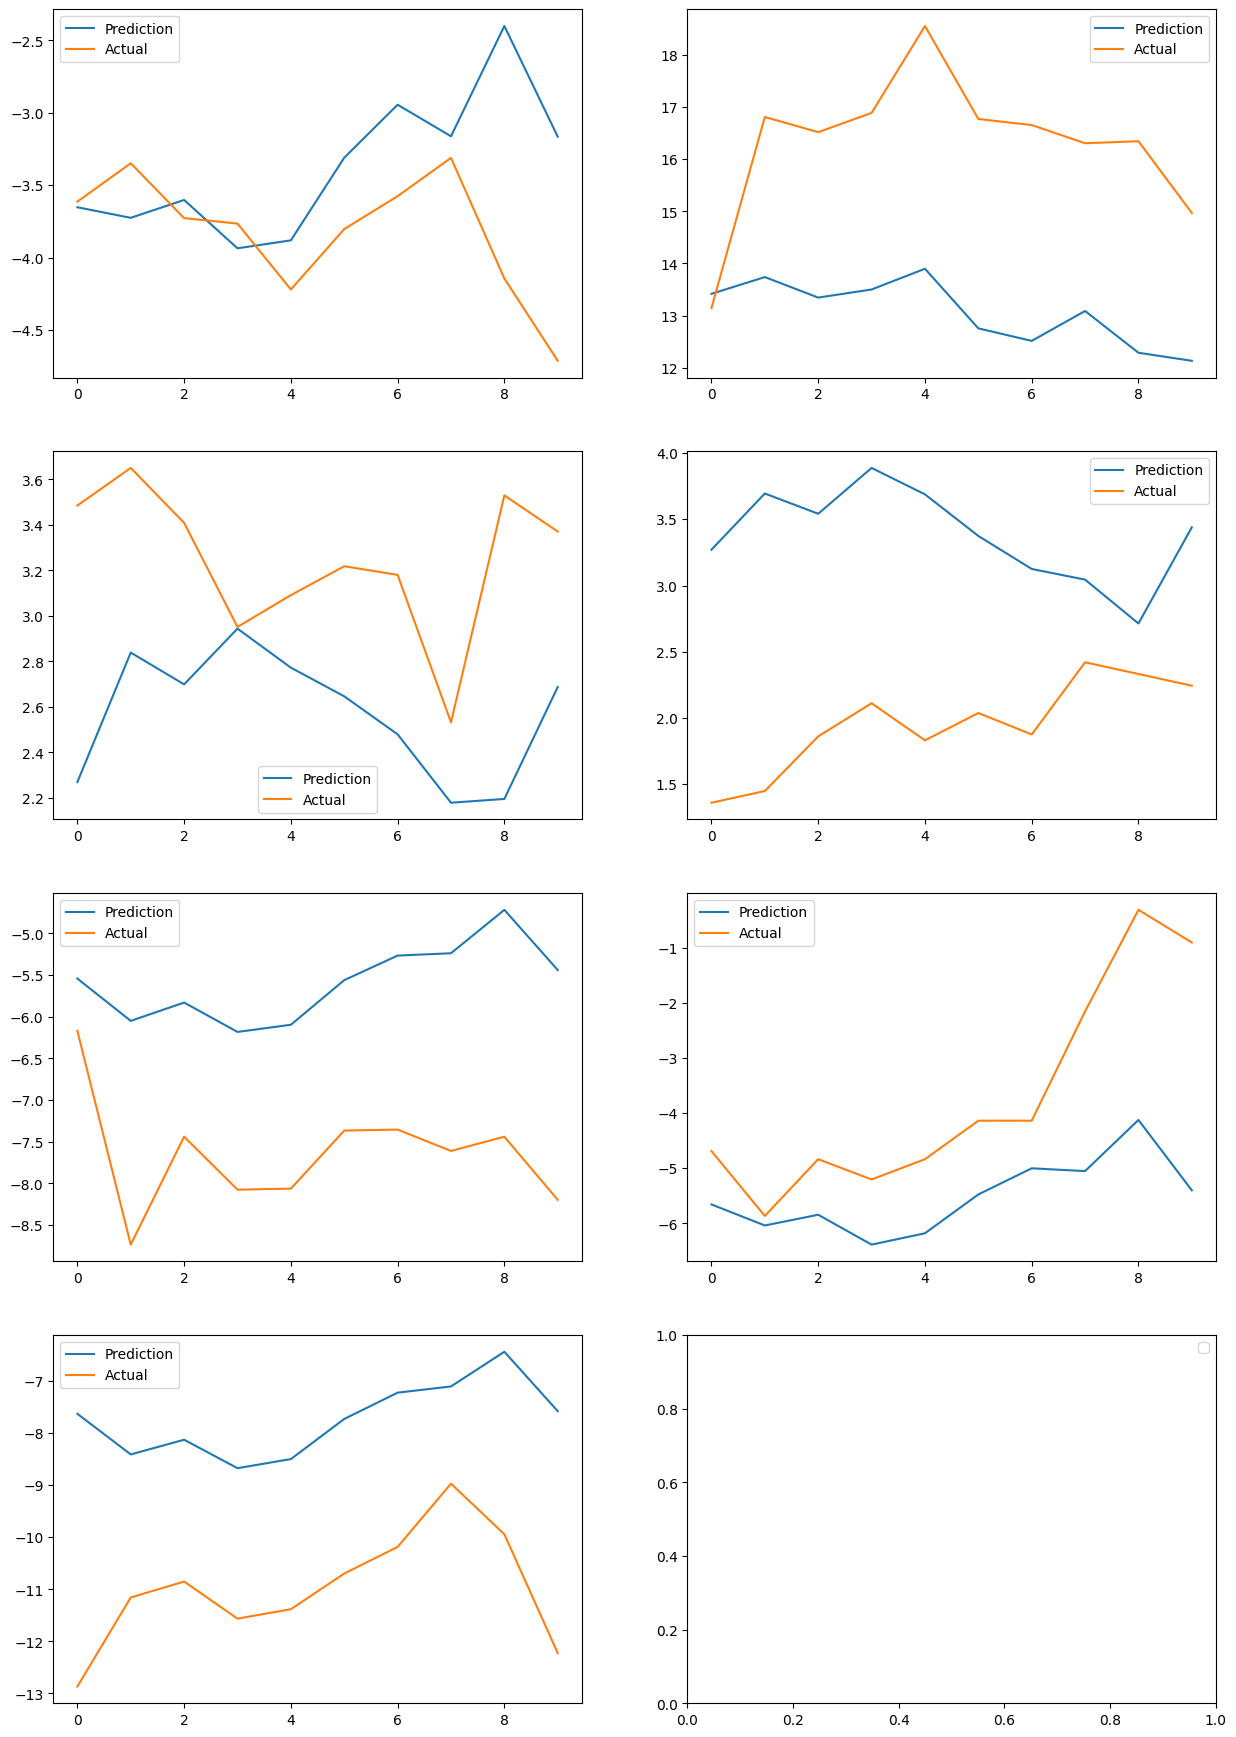

In [50]:
pred_plot_all(mod_60_FaSh, X_val60, y_val60)

In [51]:
# Fast and Long models
for i, n in enumerate([25, 34, 45, 60]):
  mods_FaLo[i].add(InputLayer((n,16)))
  mods_FaLo[i].add(GRU(64))
  mods_FaLo[i].add(Dense(16, "relu"))
  mods_FaLo[i].add(Dense(16, "relu"))
  mods_FaLo[i].add(Dense(15, "relu"))
  mods_FaLo[i].add(Dense(14, "relu"))
  mods_FaLo[i].add(Dense(7, "linear"))

  mods_FaLo[i].compile(loss=MeanSquaredError(),
                        optimizer=Adam(learning_rate=.01),
                        metrics=[RootMeanSquaredError()])

  print("Default and Long, samples = " + str(n))
  hists_FaLo[i] = mods_FaLo[i].fit(the_X_trains[i], the_y_trains[i],
  validation_data=(the_X_vals[i], the_y_vals[i]), epochs = 30,
      callbacks = [cps_FaLo[i], EarlyStopping(patience=4, start_from_epoch=6)])

  print("\n")
  print("\n")

Default and Long, samples = 25
Epoch 1/30
5/5 [==============================] - 7s 1s/step - loss: 21.7146 - root_mean_squared_error: 4.6599 - val_loss: 37.0377 - val_root_mean_squared_error: 6.0859
Epoch 2/30
5/5 [==============================] - 4s 902ms/step - loss: 11.5679 - root_mean_squared_error: 3.4012 - val_loss: 17.8486 - val_root_mean_squared_error: 4.2248
Epoch 3/30
5/5 [==============================] - 5s 1s/step - loss: 7.0908 - root_mean_squared_error: 2.6629 - val_loss: 8.4992 - val_root_mean_squared_error: 2.9153
Epoch 4/30
5/5 [==============================] - 4s 888ms/step - loss: 4.6889 - root_mean_squared_error: 2.1654 - val_loss: 4.3904 - val_root_mean_squared_error: 2.0953
Epoch 5/30
5/5 [==============================] - 0s 24ms/step - loss: 3.5284 - root_mean_squared_error: 1.8784 - val_loss: 5.7723 - val_root_mean_squared_error: 2.4026
Epoch 6/30
5/5 [==============================] - 4s 885ms/step - loss: 3.2661 - root_mean_squared_error: 1.8072 - val_los

In [52]:
for i, n in enumerate([25, 34, 45, 60]):
  print(str(min(hists_FaLo[i].history['val_root_mean_squared_error'])
  ) + " = Fast/Long best Val RMSE with samples sized " + str(n))
  print("\n")

1.299853801727295 = Fast/Long best Val RMSE with samples sized 25


1.803655743598938 = Fast/Long best Val RMSE with samples sized 34


1.9329054355621338 = Fast/Long best Val RMSE with samples sized 45


1.714281439781189 = Fast/Long best Val RMSE with samples sized 60




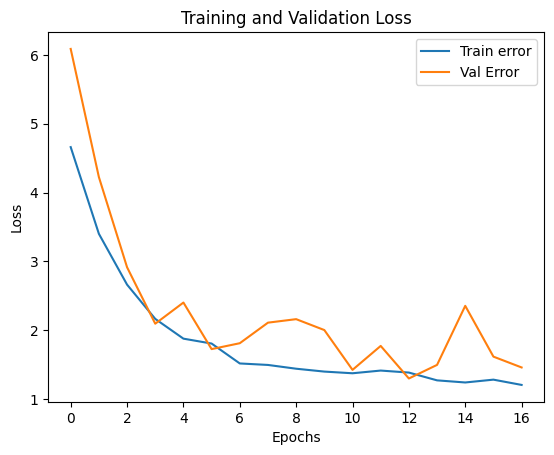

In [53]:
plot_error(hists_FaLo[0])

1/1 [==============================] - 0s 450ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


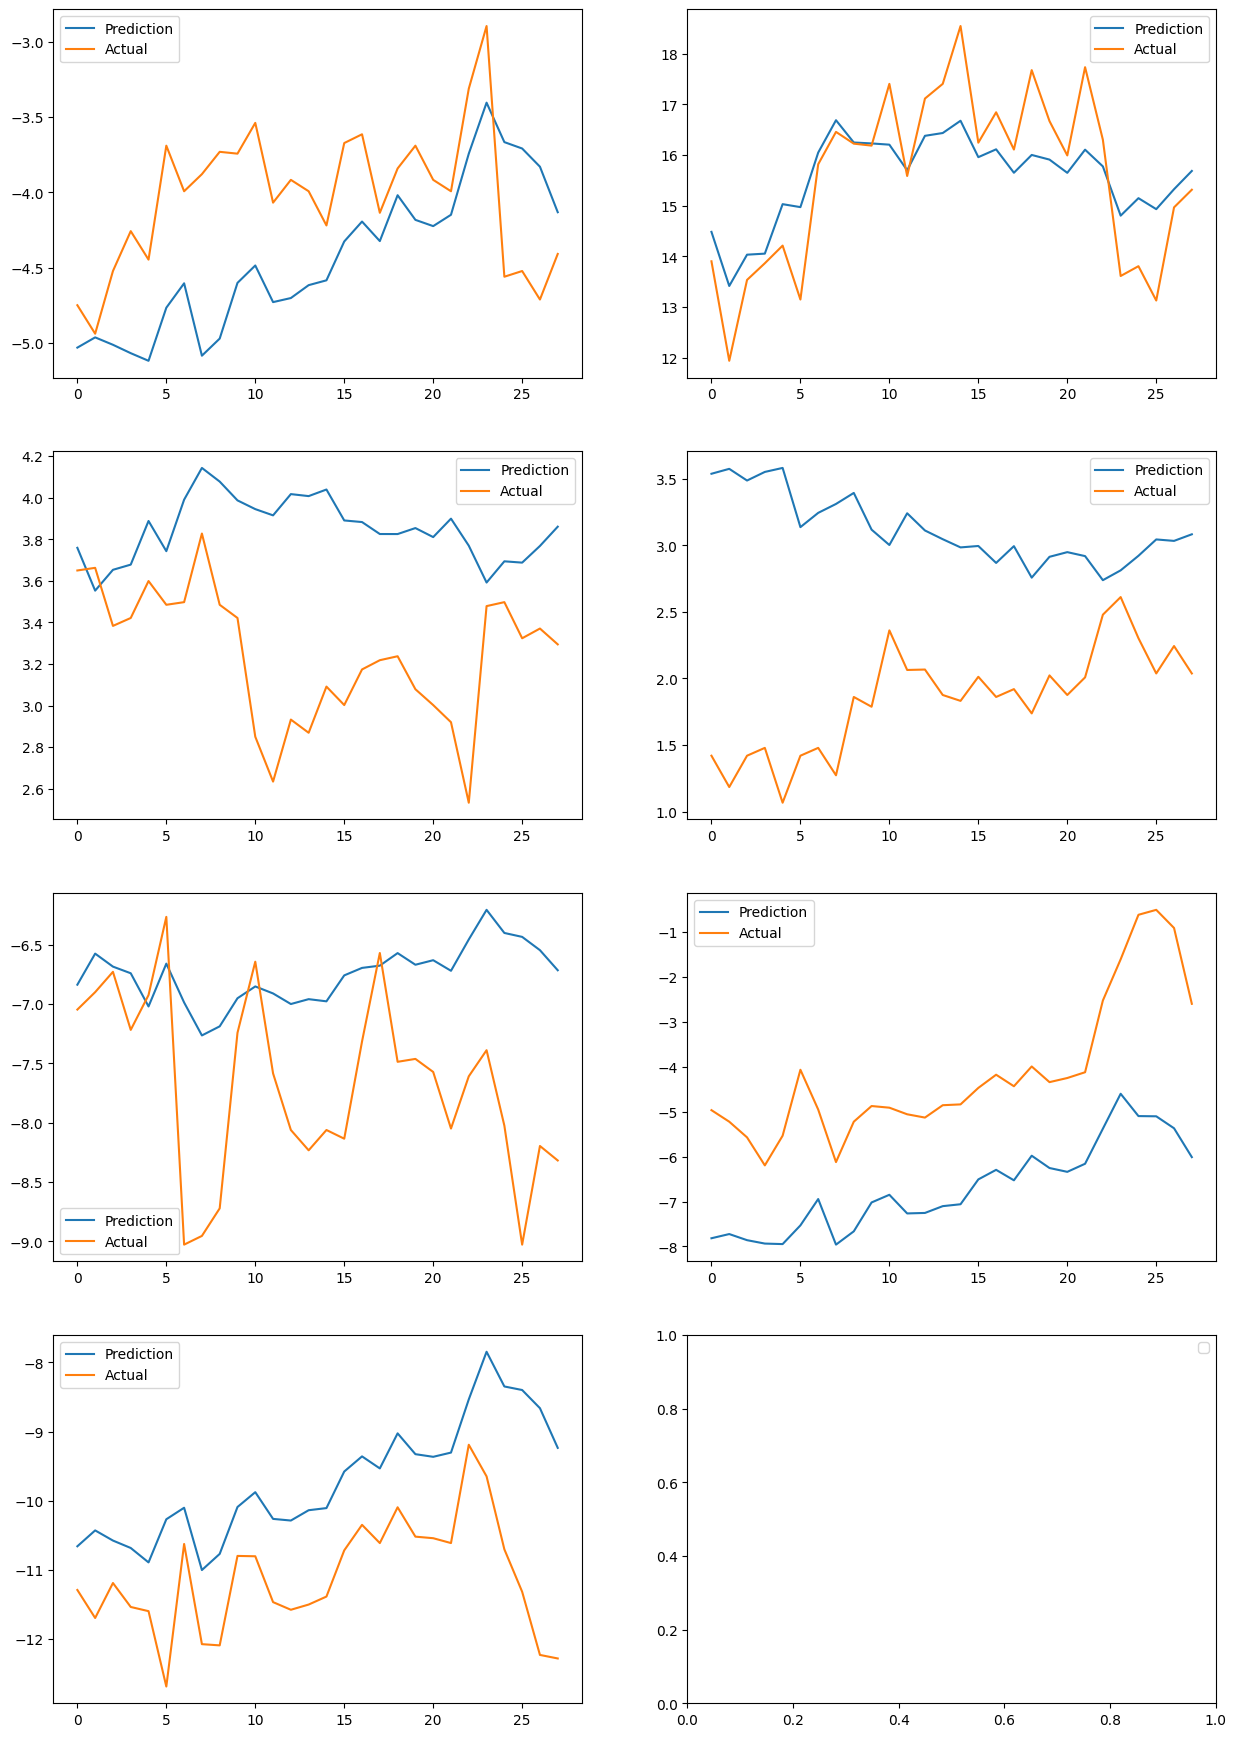

In [54]:
 pred_plot_all(mod_25_FaLo, X_val25, y_val25)

1/1 [==============================] - 0s 425ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


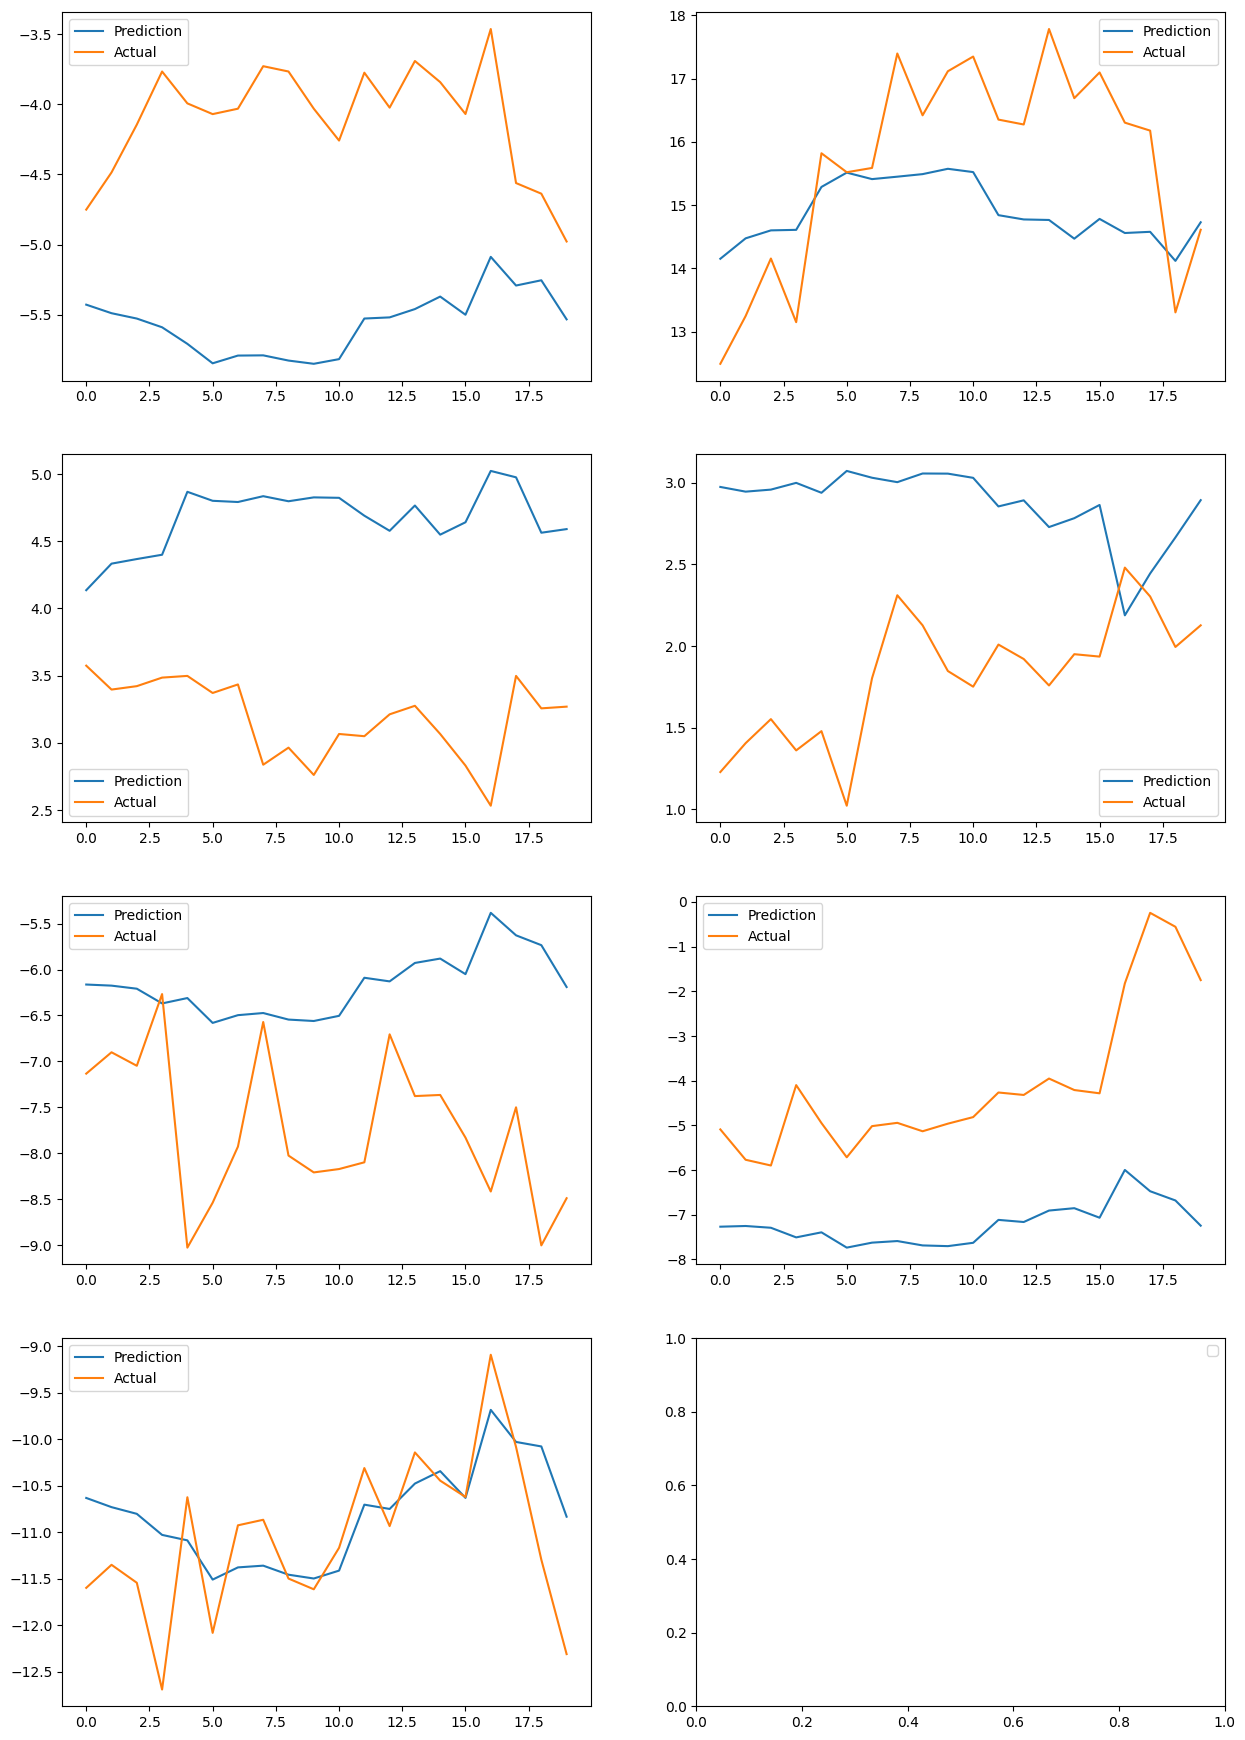

In [55]:
pred_plot_all(mod_34_FaLo, X_val34, y_val34)

1/1 [==============================] - 0s 421ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


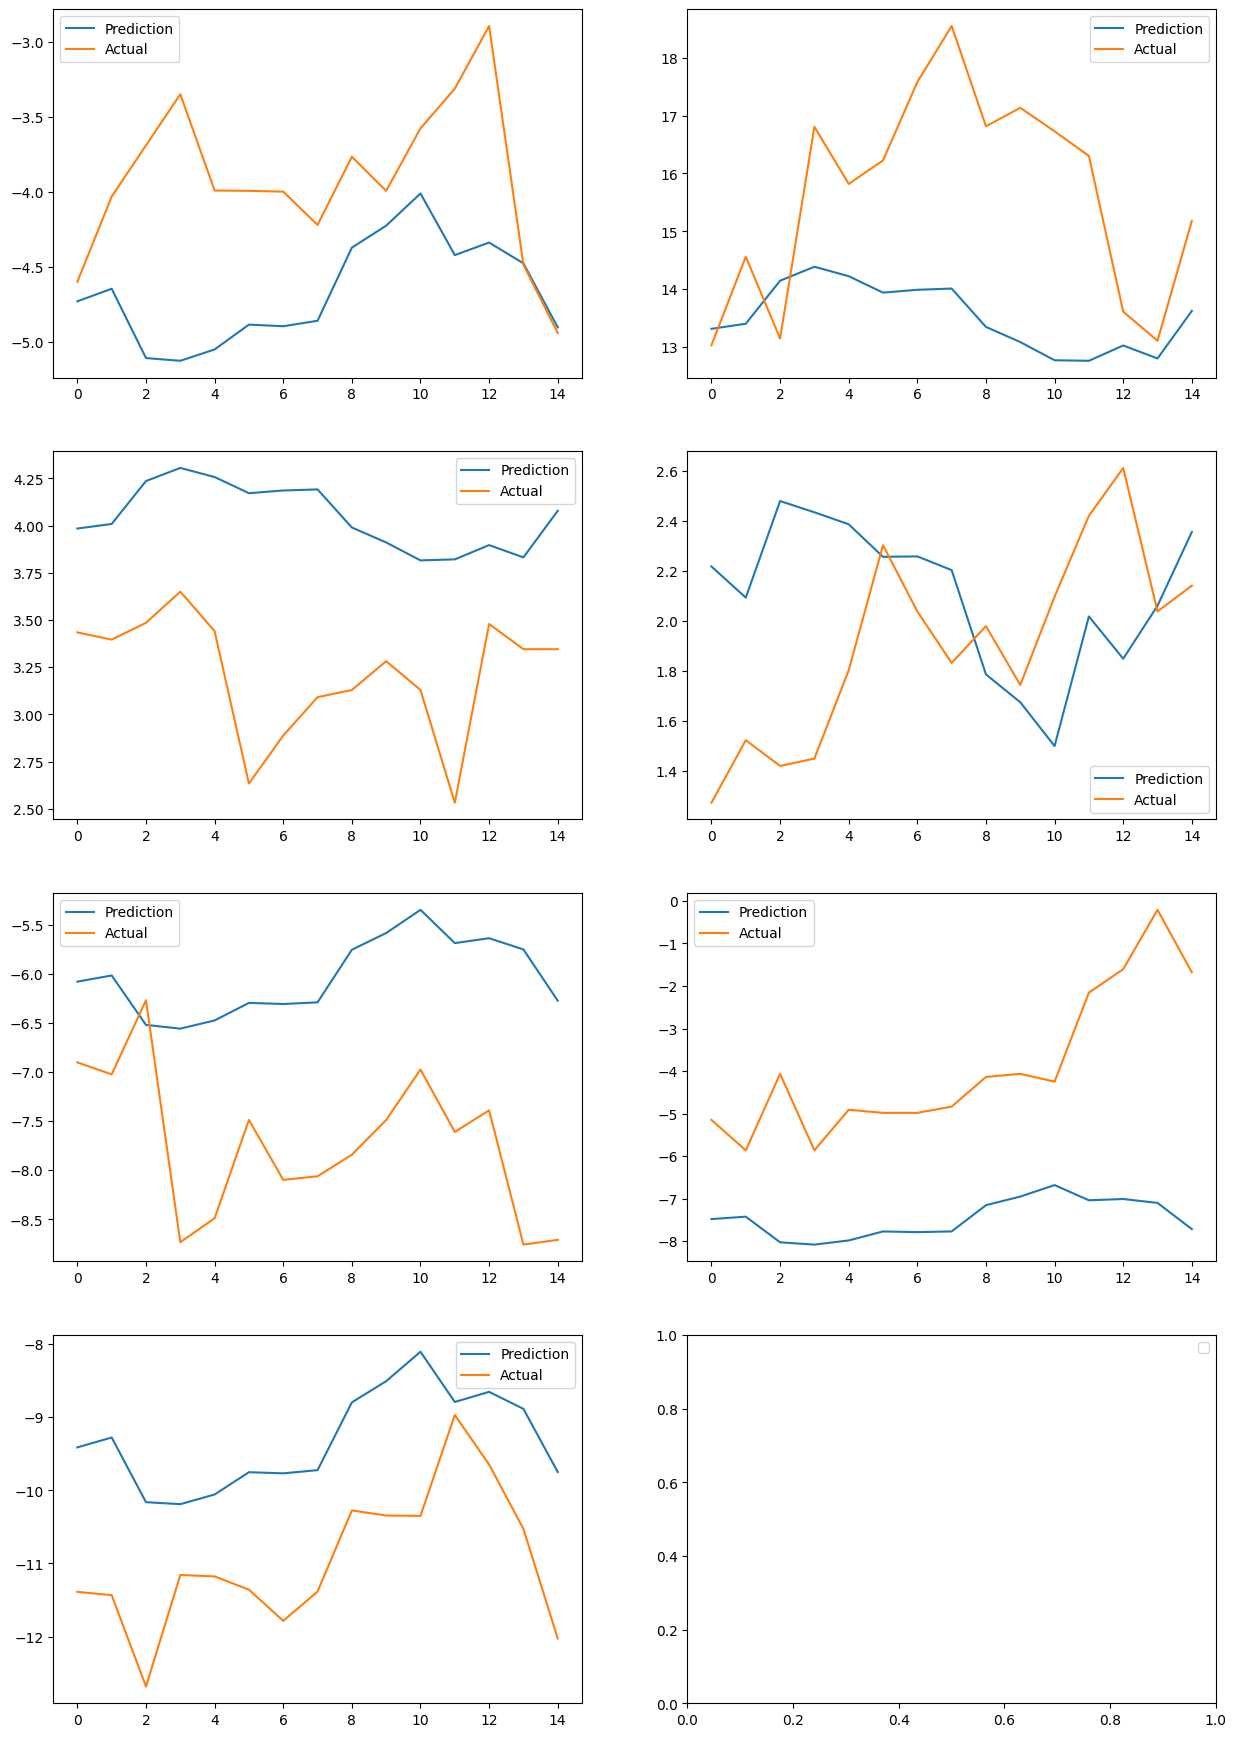

In [56]:
pred_plot_all(mod_45_FaLo, X_val45, y_val45)

1/1 [==============================] - 1s 607ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step


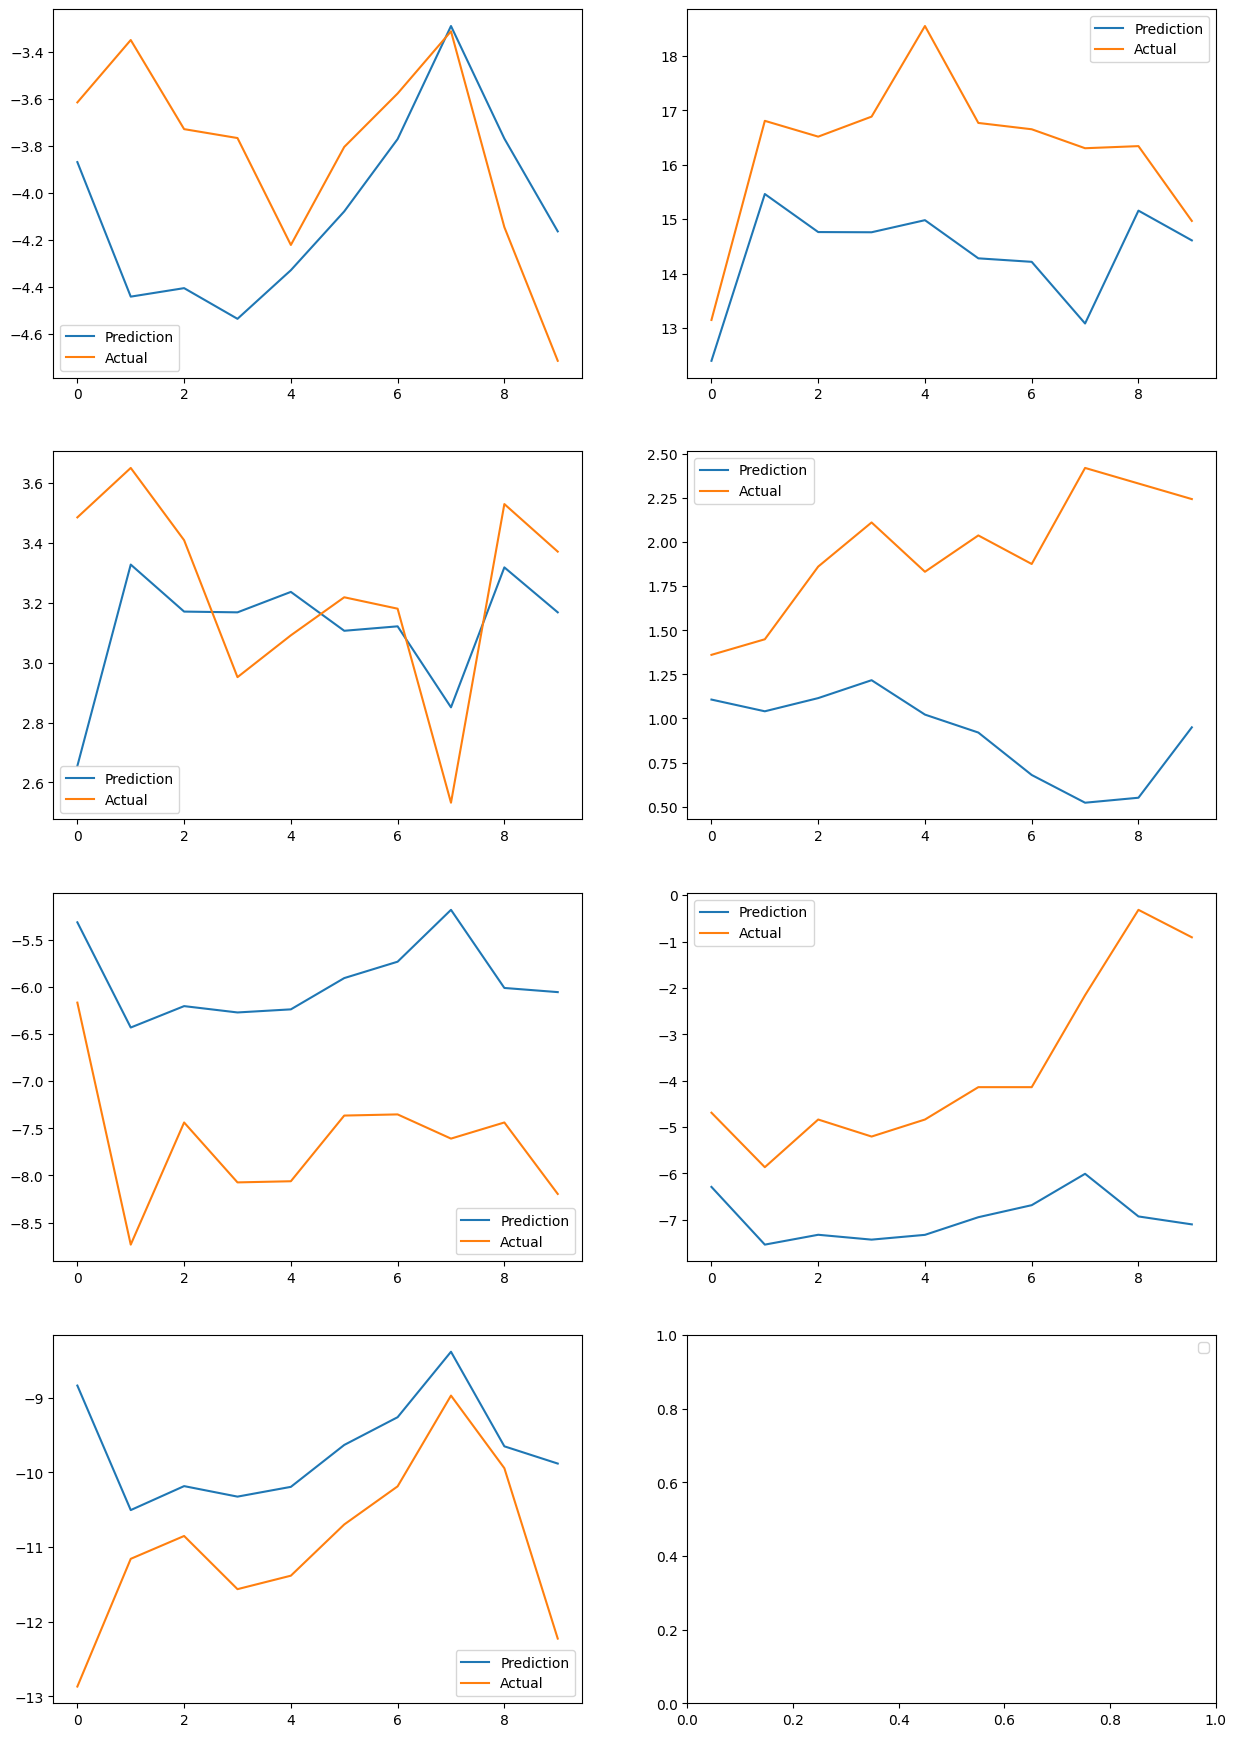

In [57]:
pred_plot_all(mod_60_FaLo, X_val60, y_val60)

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


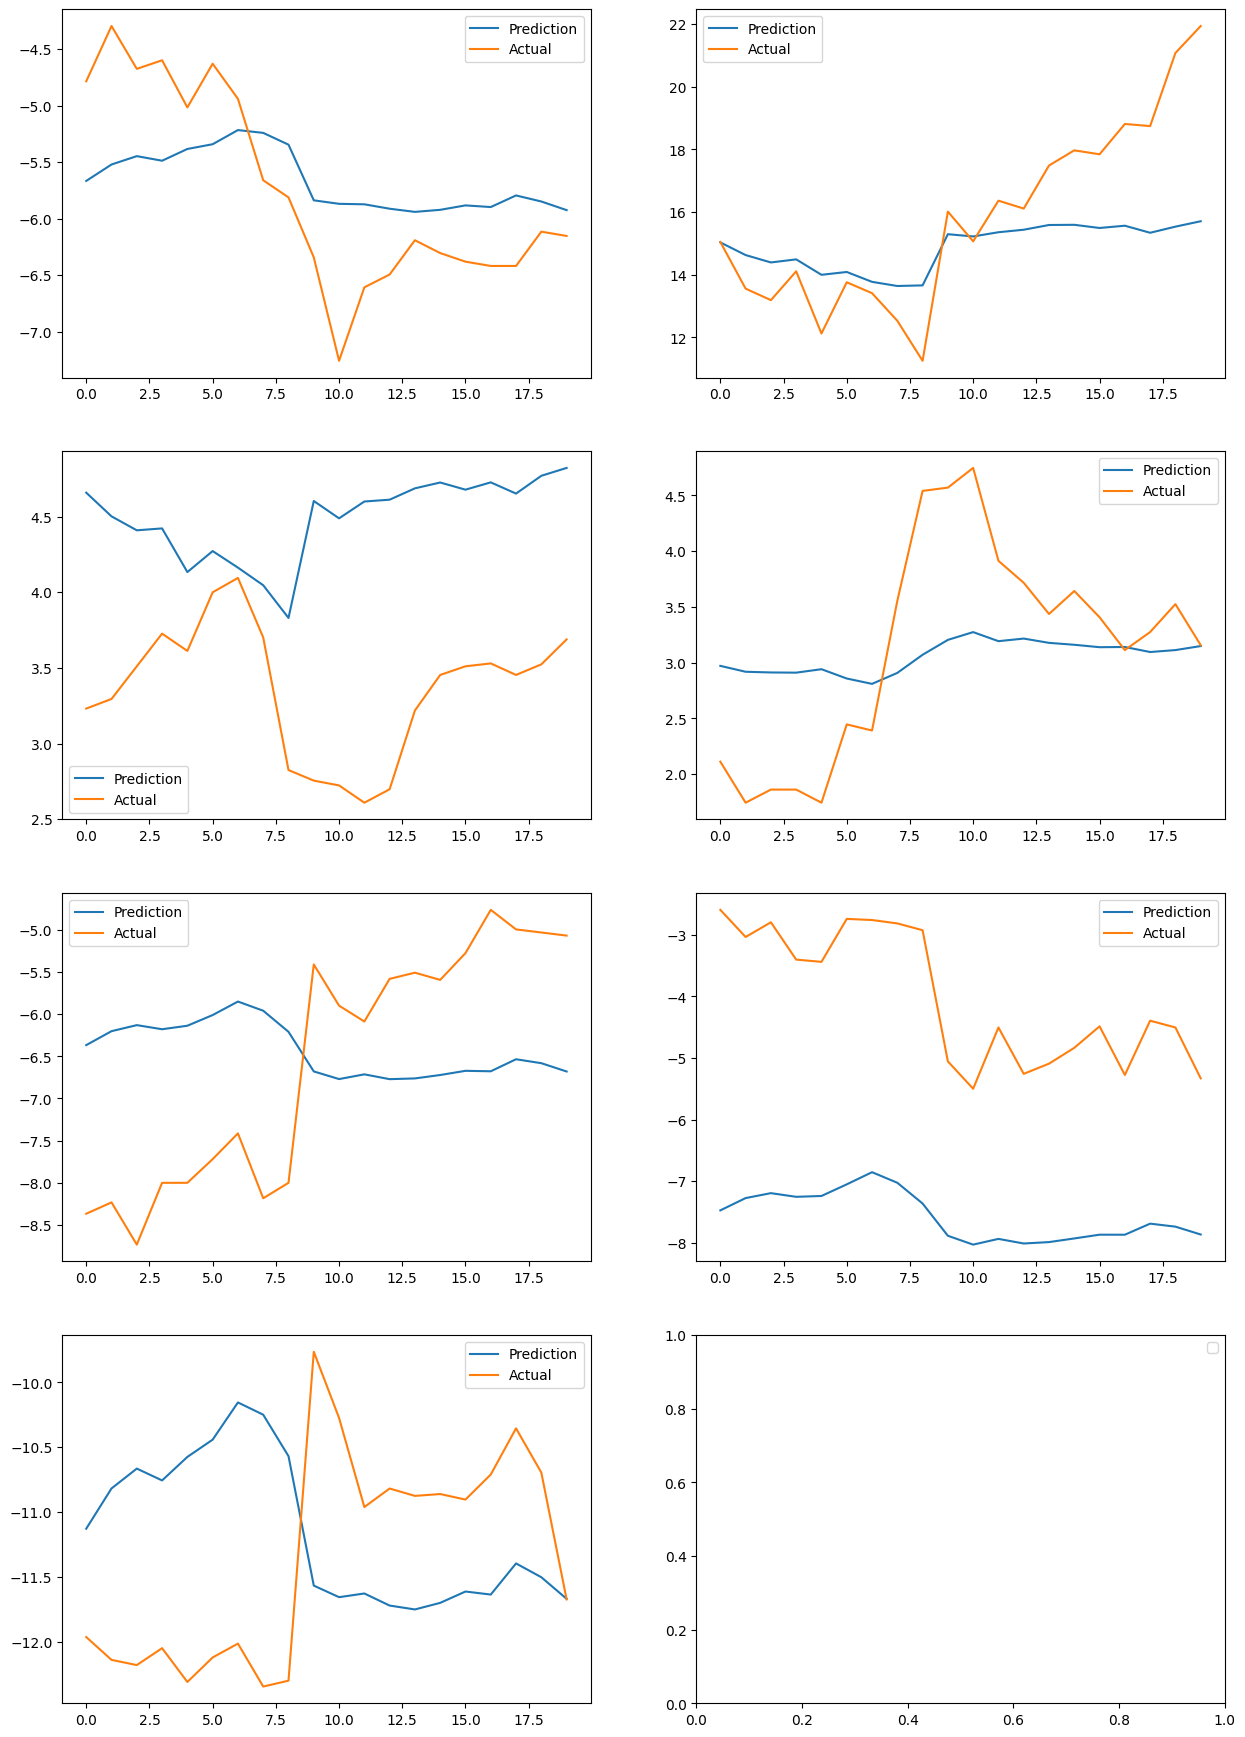

In [58]:
pred_plot_all(mod_34_FaLo, X_test34, y_test34)

In [59]:
3+5

8